In [1]:
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import statsmodels.api as sm

In [2]:
from fredapi import Fred
fred = Fred(api_key="a8e786933fbeaea707d27cc461bff878")

In [3]:
# s_gdp = fred.get_series_first_release('GDP').rename("gdp") # do not use this, it is quarterly
# s_birth_rate = fred.get_series_first_release('SPDYNCBRTINUSA').rename("birth_rate")

s_fedrate = fred.get_series_first_release('FEDFUNDS').rename("fed_rate")
s_tbyield = fred.get_series_first_release('GS10').rename("treasury_10y")

s_30mortgage = fred.get_series_first_release('MORTGAGE30US').rename("mortgage_30y")
# s_15mortgage = fred.get_series_first_release('MORTGAGE15US').rename("15y_mortgage")

s_savings = fred.get_series_first_release('PSAVERT').rename("savings")

s_cpi = fred.get_series_first_release('CPIAUCSL').rename("cpi") # can be used to calculate inflation
s_cpi_less_food_energy = fred.get_series_first_release('CPILFESL').rename("cpi_less_food_energy") # can be used to calculate inflation
s_unemployment = fred.get_series_first_release('UNRATE').rename('unemployment')

In [4]:
s_population = fred.get_series_first_release('POPTHM').rename('population')
# s_work_population = fred.get_series_first_release('LFWA64TTUSM647S').rename('workforce_population')
s_employment = fred.get_series_first_release('PAYEMS').rename('employment')

In [5]:
s_home_price = fred.get_series_first_release('CSUSHPISA').rename('home_price')

In [6]:
df_raw = pd.concat([s_fedrate, s_tbyield, s_savings, 
                    s_cpi, s_cpi_less_food_energy, s_unemployment, 
                    s_population, s_employment, s_home_price], 
                   axis=1)

In [7]:
df_raw = df_raw["1975-01-01": "2023-08-01"]

In [8]:
# We merge the weekly mortgage rate with other monthly data by using the backward method
df = pd.merge_asof(df_raw, s_30mortgage.to_frame(), left_index=True, right_index=True, direction='backward')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 584 entries, 1975-01-01 to 2023-08-01
Freq: MS
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fed_rate              584 non-null    object
 1   treasury_10y          584 non-null    object
 2   savings               584 non-null    object
 3   cpi                   584 non-null    object
 4   cpi_less_food_energy  584 non-null    object
 5   unemployment          584 non-null    object
 6   population            584 non-null    object
 7   employment            584 non-null    object
 8   home_price            584 non-null    object
 9   mortgage_30y          584 non-null    object
dtypes: object(10)
memory usage: 50.2+ KB


In [10]:
df = df.apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 584 entries, 1975-01-01 to 2023-08-01
Freq: MS
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fed_rate              584 non-null    float64
 1   treasury_10y          584 non-null    float64
 2   savings               584 non-null    float64
 3   cpi                   584 non-null    float64
 4   cpi_less_food_energy  584 non-null    float64
 5   unemployment          584 non-null    float64
 6   population            584 non-null    float64
 7   employment            584 non-null    float64
 8   home_price            584 non-null    float64
 9   mortgage_30y          584 non-null    float64
dtypes: float64(10)
memory usage: 50.2 KB


In [11]:
s_30mortgage["1974-12-27":]

date
1974-12-27    9.56
1975-01-03     9.6
1975-01-10    9.49
1975-01-17    9.43
1975-01-24    9.35
              ... 
2023-10-12    7.57
2023-10-19    7.63
2023-10-26    7.79
2023-11-02    7.76
2023-11-09     7.5
Name: mortgage_30y, Length: 2551, dtype: object

## Train Test Split
We follow 5-to-1 split
- Train: `1975-01-01` to `2015-07-01`
- Test: `2015-08-01` to `2023-08-01`

In [12]:
df_train = df[:-97].copy()
df_test = df[-97:].copy()

In [13]:
df_test.tail()

fed_rate  treasury_10y  savings      cpi  cpi_less_food_energy  \
date                                                                         
2023-04-01      4.83          3.46      4.1  302.918               306.489   
2023-05-01      5.06          3.57      4.6  303.294               307.824   
2023-06-01      5.08          3.75      4.3  303.841               308.309   
2023-07-01      5.12          3.90      3.5  304.348               308.801   
2023-08-01      5.33          4.17      3.9  306.269               309.661   

            unemployment  population  employment  home_price  mortgage_30y  
date                                                                        
2023-04-01           3.4    334880.0    155673.0     299.715          6.32  
2023-05-01           3.7    335013.0    156105.0     302.375          6.43  
2023-06-01           3.6    335163.0    156204.0     304.635          6.79  
2023-07-01           3.5    335329.0    156342.0     306.720          6.71  
2023-08-01           3.8    335501.0    156419.0     309.404          6.81

In [14]:
s_home_price.head()

date
1975-01-01    25.27
1975-02-01    25.34
1975-03-01    25.37
1975-04-01    25.37
1975-05-01    25.39
Name: home_price, dtype: object

# EDA

## Home price

In [15]:
s_home_price.head()

date
1975-01-01    25.27
1975-02-01    25.34
1975-03-01    25.37
1975-04-01    25.37
1975-05-01    25.39
Name: home_price, dtype: object

In [16]:
s_home_price.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 584 entries, 1975-01-01 to 2023-08-01
Series name: home_price
Non-Null Count  Dtype 
--------------  ----- 
584 non-null    object
dtypes: object(1)
memory usage: 25.3+ KB


In [17]:
s_home_price = pd.to_numeric(s_home_price, errors='coerce')
s_home_price.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 584 entries, 1975-01-01 to 2023-08-01
Series name: home_price
Non-Null Count  Dtype  
--------------  -----  
584 non-null    float64
dtypes: float64(1)
memory usage: 25.3 KB


In [18]:
s_home_price.describe()

count    584.000000
mean     117.424267
std       67.792061
min       25.270000
25%       64.682500
50%       95.110000
75%      165.562500
max      309.404000
Name: home_price, dtype: float64

In [19]:
s_home_price_test = s_home_price.iloc[-97:]
s_home_price = s_home_price.iloc[:-97]

###  Trend

In [20]:
import hvplot

There is an obvious upward close-to-linear trend, so we try a log difference and percentage change to see if we can remove the trend from the times series

In [21]:
hprice_plot = s_home_price.hvplot()
hvplot.save(hprice_plot, 'hprice_plot.png')

In [22]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

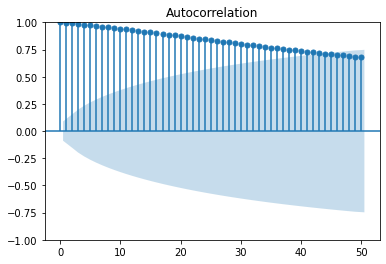

In [23]:
plot_acf(s_home_price, lags=50)
plt.show()

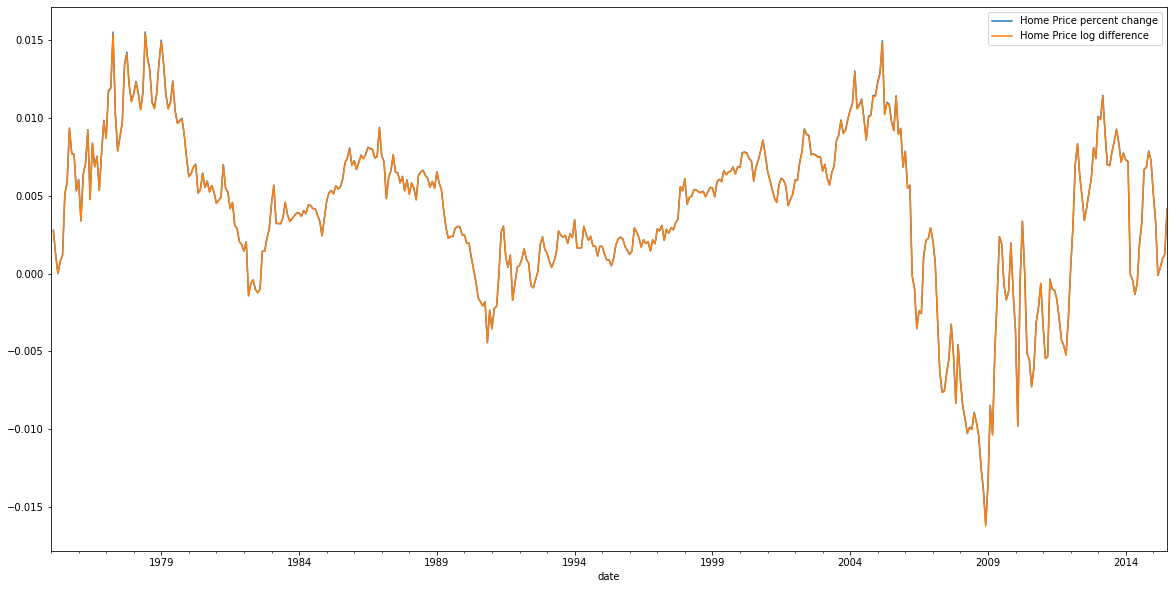

In [24]:
plt.figure(figsize=(20,10))
s_home_price.pct_change().plot(label="Home Price percent change")
np.log(pd.to_numeric(s_home_price)).diff().plot(label="Home Price log difference")
plt.legend()
plt.show()

<Axes: xlabel='date'>

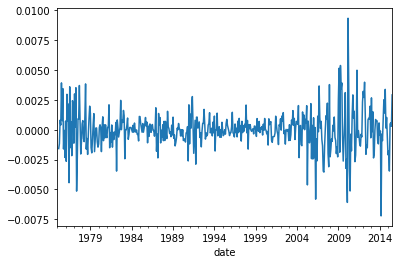

In [26]:
log_price_diff = np.log(pd.to_numeric(s_home_price)).diff()
log_price_diff_diff = log_price_diff.diff()
log_price_diff_diff.plot()

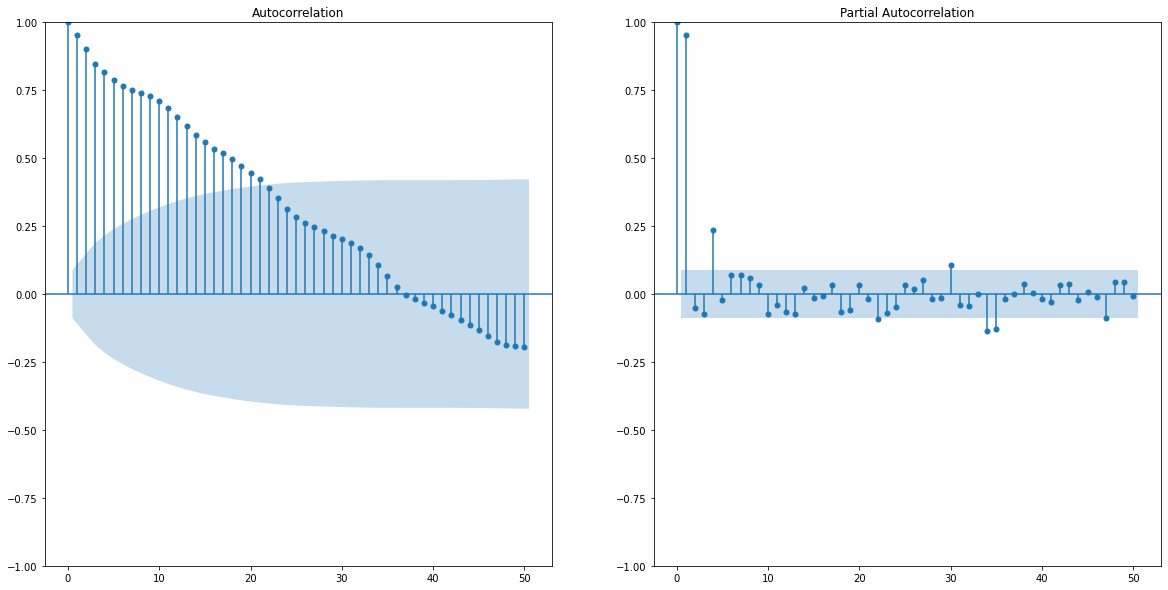

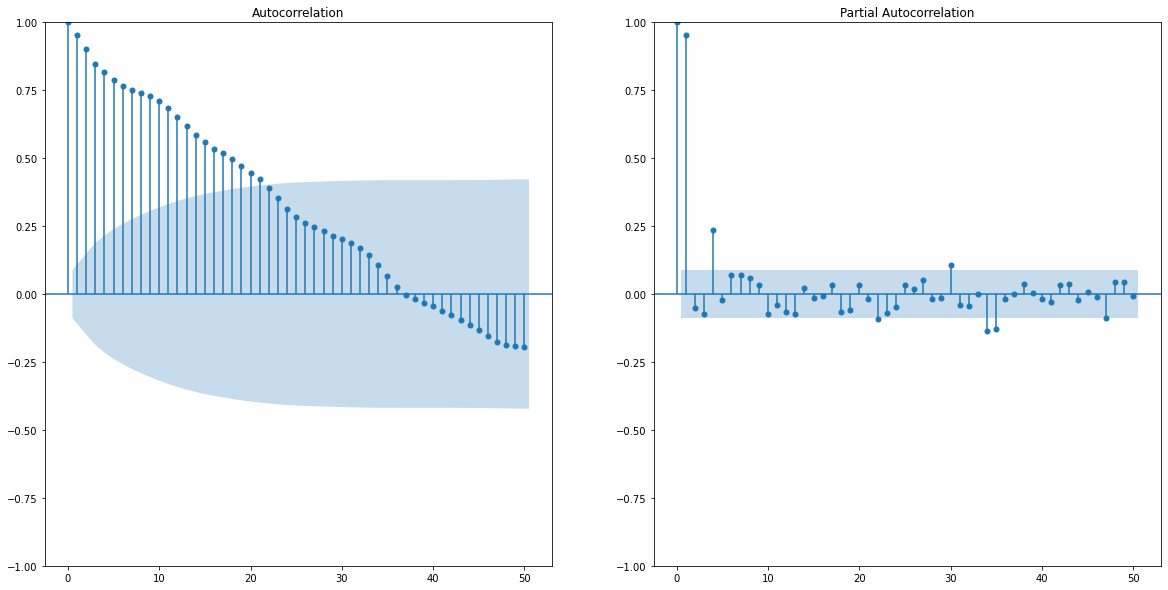

In [26]:
log_price_diff = np.log(pd.to_numeric(s_home_price)).diff()
fig, ax = plt.subplots(1, 2, figsize=(20,10))
plot_acf(log_price_diff[1:], lags=50, ax=ax[0])
plot_pacf(log_price_diff[1:], lags=50, ax=ax[1])

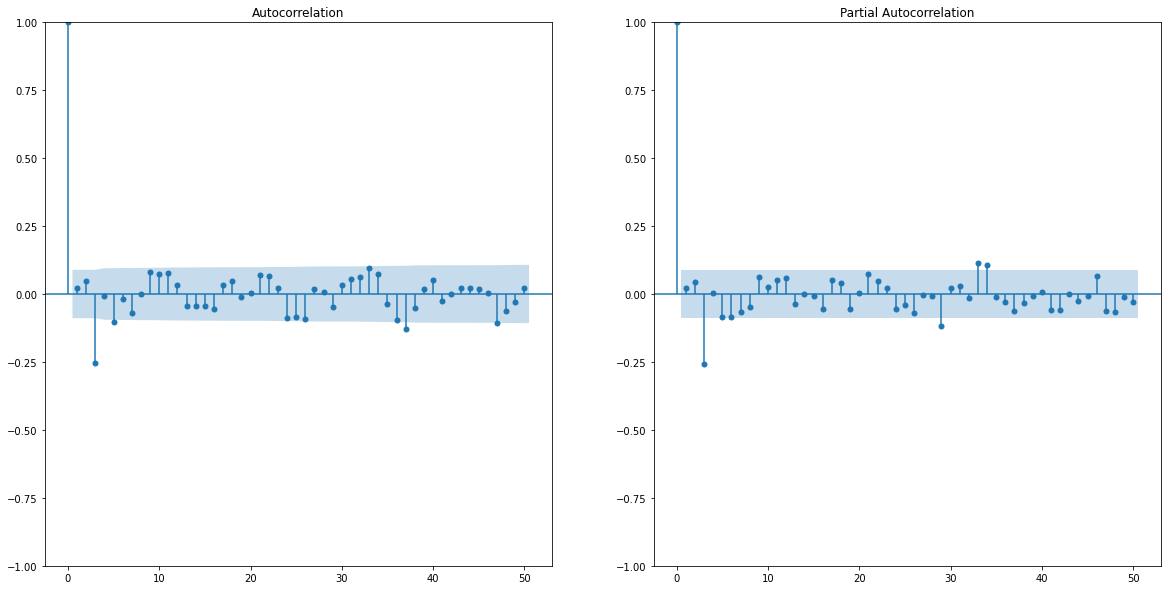

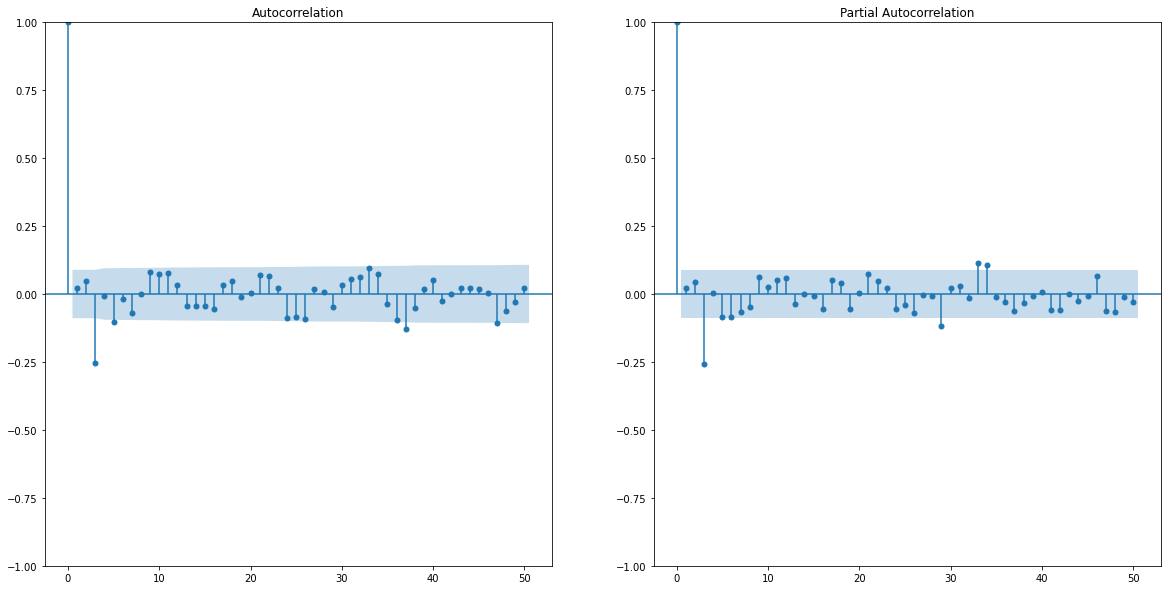

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
plot_acf(log_price_diff_diff[2:], lags=50, ax=ax[0])
plot_pacf(log_price_diff_diff[2:], lags=50, ax=ax[1])

### Check the if the log difference is Trend Stationary

https://www.kaggle.com/code/bextuychiev/how-to-remove-non-stationarity-from-time-series

In [31]:
from statsmodels.tsa.stattools import adfuller

stationarity_test = adfuller(log_price_diff[1:])
print('ADF Statistic: %f' % stationarity_test[0])
print('p-value: %f' % stationarity_test[1])
print('Critical Values:')
for key, value in stationarity_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.950674
p-value: 0.039765
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


In [32]:
stationarity_test = adfuller(log_price_diff_diff[2:])
print('ADF Statistic: %f' % stationarity_test[0])
print('p-value: %f' % stationarity_test[1])
print('Critical Values:')
for key, value in stationarity_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.575978
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


### STL Decomposition

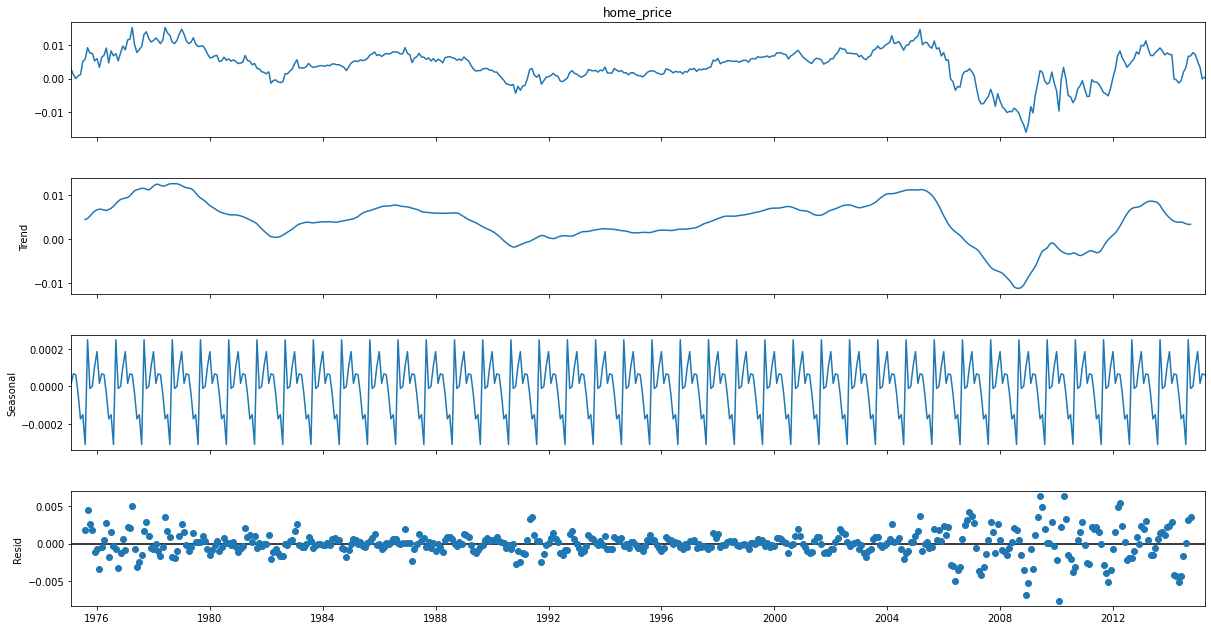

In [131]:
res = sm.tsa.seasonal_decompose(log_price_diff[1:-100], model='additive')
resplot = res.plot().set_size_inches(20,10)

### Datetime - Month, Year

In [25]:
s_home_price_df = s_home_price.to_frame()
s_home_price_df['datetime'] = s_home_price_df.index

In [26]:
s_home_price_df['year'] = s_home_price_df['datetime'].dt.year
s_home_price_df['month'] = s_home_price_df['datetime'].dt.month

In [27]:
s_home_price_df['log_price_diff'] = log_price_diff

In [28]:
s_home_price_df.head()

home_price   datetime  year  month  log_price_diff
date                                                          
1975-01-01       25.27 1975-01-01  1975      1             NaN
1975-02-01       25.34 1975-02-01  1975      2        0.002766
1975-03-01       25.37 1975-03-01  1975      3        0.001183
1975-04-01       25.37 1975-04-01  1975      4        0.000000
1975-05-01       25.39 1975-05-01  1975      5        0.000788

From Autocorrelation plots and boxplots below, we do not see clear seasonal pattern in log difference of home price index

<Axes: xlabel='month', ylabel='log_price_diff'>

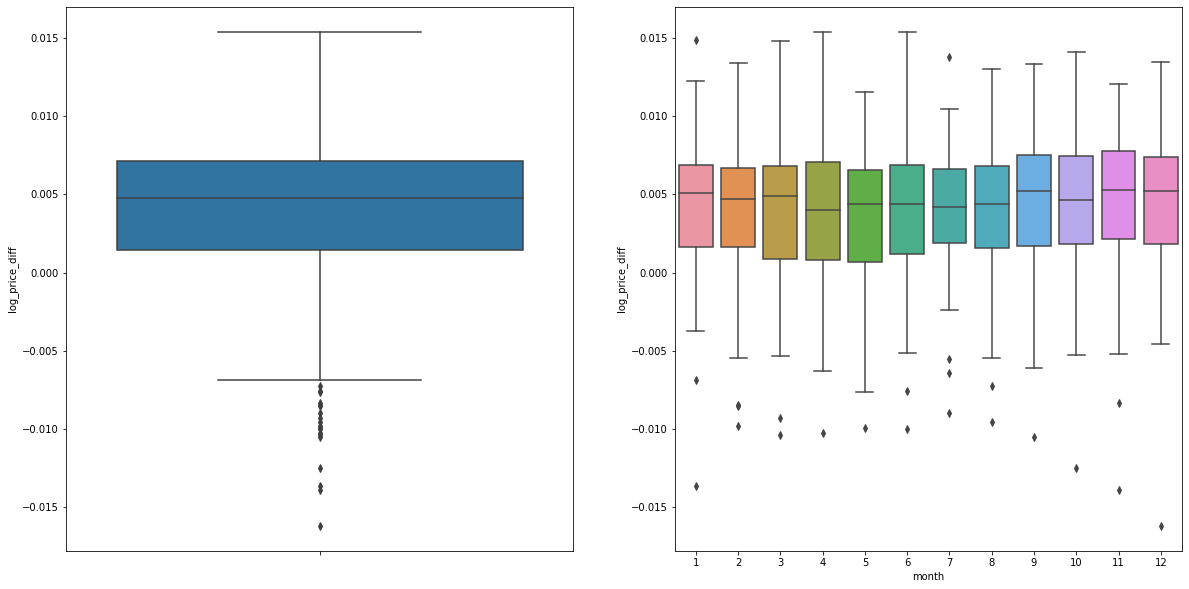

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
sns.boxplot(orient="v", y='log_price_diff', data=s_home_price_df, ax=axes[0])
sns.boxplot(x='month', y='log_price_diff', data=s_home_price_df, ax=axes[1])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height

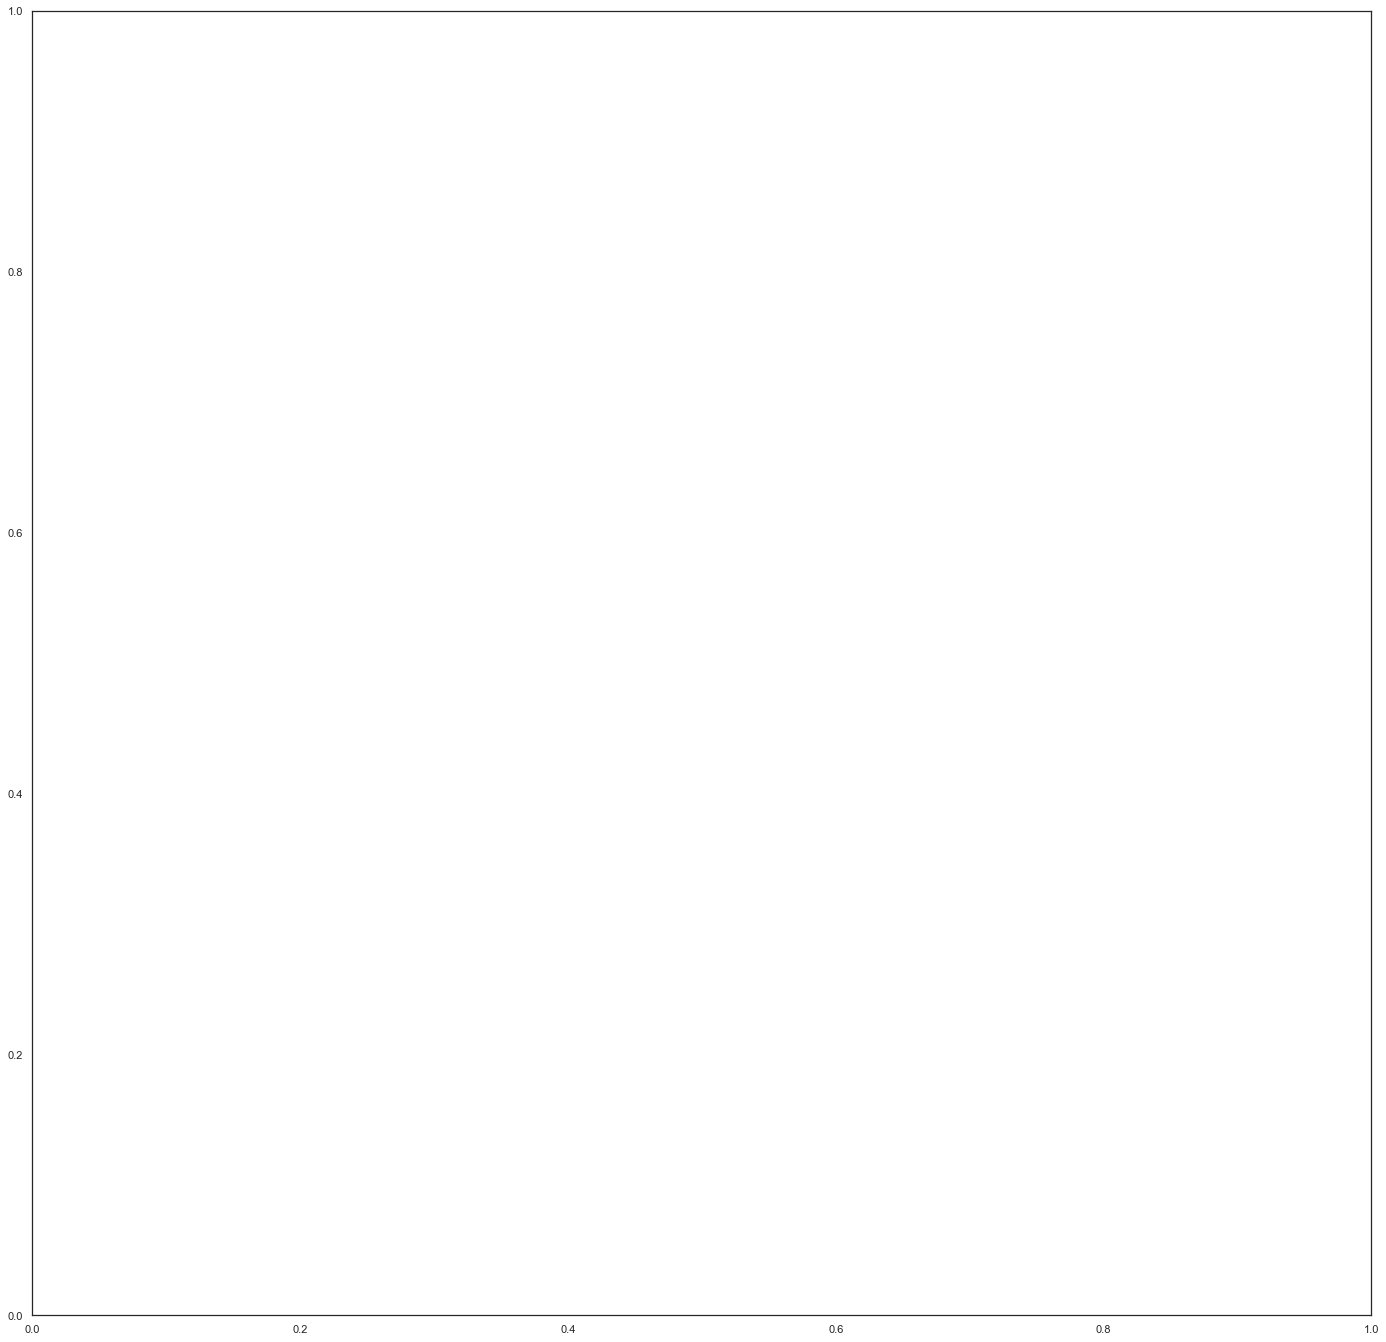

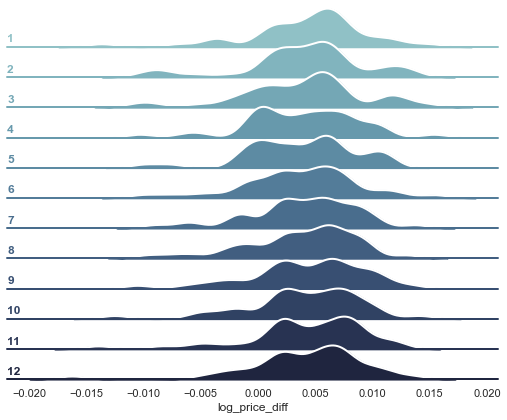

In [35]:
# Ridge plot of log price difference by month
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
fig, ax = plt.subplots(figsize=(24,24))
pal = sns.cubehelix_palette(12, rot=-.25, light=.7)
g = sns.FacetGrid(s_home_price_df, row="month", hue="month", aspect=15, height=.5, palette=pal)
g.map(sns.kdeplot, "log_price_diff", 
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "log_price_diff", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "log_price_diff")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [27]:
df_train["log_price_diff"] = np.log(df_train["home_price"]).diff()

We add the same date time features to test set

In [31]:
s_home_price_test

date
2015-08-01    172.320
2015-09-01    173.650
2015-10-01    175.200
2015-11-01    176.640
2015-12-01    177.850
               ...   
2023-04-01    299.715
2023-05-01    302.375
2023-06-01    304.635
2023-07-01    306.720
2023-08-01    309.404
Name: home_price, Length: 97, dtype: float64

In [32]:
log_price_diff_test = np.log(pd.to_numeric(s_home_price_test)).diff()
s_home_price_df_test = s_home_price_test.to_frame()
s_home_price_df_test['datetime'] = s_home_price_test.index
s_home_price_df_test['year'] = s_home_price_df_test['datetime'].dt.year
s_home_price_df_test['month'] = s_home_price_df_test['datetime'].dt.month
s_home_price_df_test['log_price_diff'] = log_price_diff_test

In [33]:
s_home_price_df_test.head()

home_price   datetime  year  month  log_price_diff
date                                                          
2015-08-01      172.32 2015-08-01  2015      8             NaN
2015-09-01      173.65 2015-09-01  2015      9        0.007689
2015-10-01      175.20 2015-10-01  2015     10        0.008886
2015-11-01      176.64 2015-11-01  2015     11        0.008186
2015-12-01      177.85 2015-12-01  2015     12        0.006827

### Distribution of response variable

In [28]:
log_price_diff.describe()

count    486.000000
mean       0.003943
std        0.005057
min       -0.016205
25%        0.001435
50%        0.004751
75%        0.007163
max        0.015385
Name: home_price, dtype: float64

<Axes: ylabel='Density'>

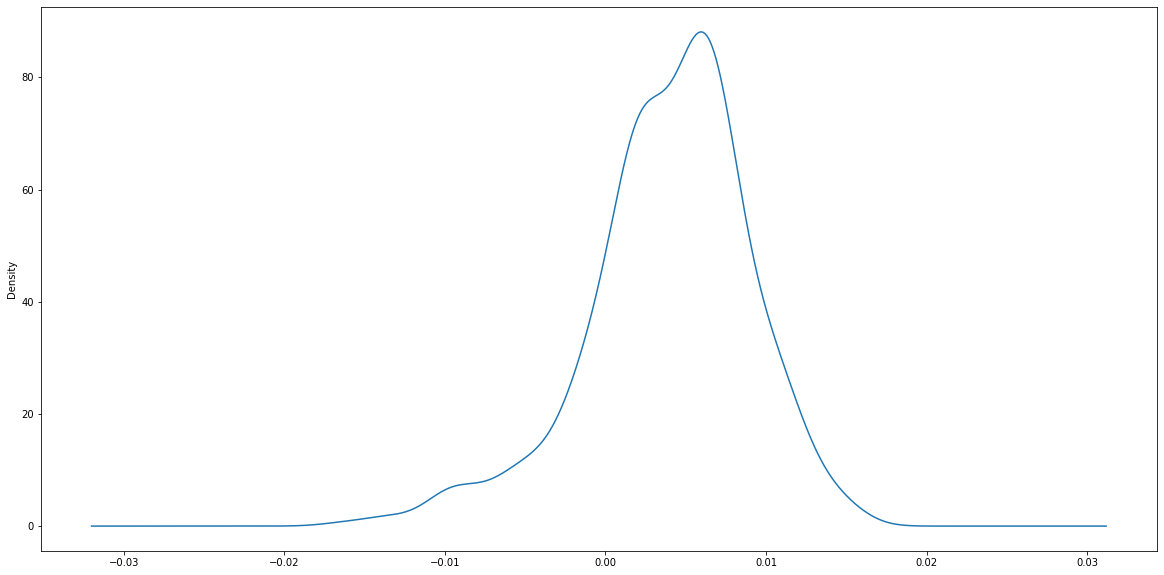

In [35]:
log_price_diff.plot(kind='kde', figsize=(20,10))

Distribution of the log difference looks close to a normal distribution. The QQ-plot shows the distribution of log difference matches normal distribution except at large tail (especially left tail)

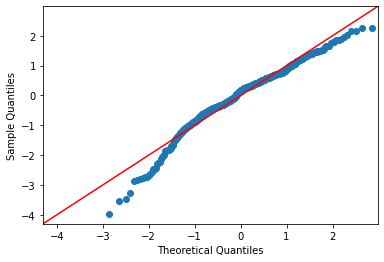

In [36]:
pplot = sm.ProbPlot(log_price_diff[1:], fit=True)
fig = pplot.qqplot(line='45')
plt.show()

## GDP

In [57]:
s_gdp = s_gdp['1975-01-01':]

In [58]:
s_gdp

date
1975-01-01       1512.7
1975-04-01       1551.2
1975-07-01       1613.3
1975-10-01       1662.1
1976-01-01       1716.5
                ...    
2022-07-01    25663.289
2022-10-01    26132.458
2023-01-01    26465.865
2023-04-01    26834.953
2023-07-01    27623.543
Name: gdp, Length: 195, dtype: object

In [59]:
s_gdp.pct_change().hvplot()

:Curve   [date]   (gdp)

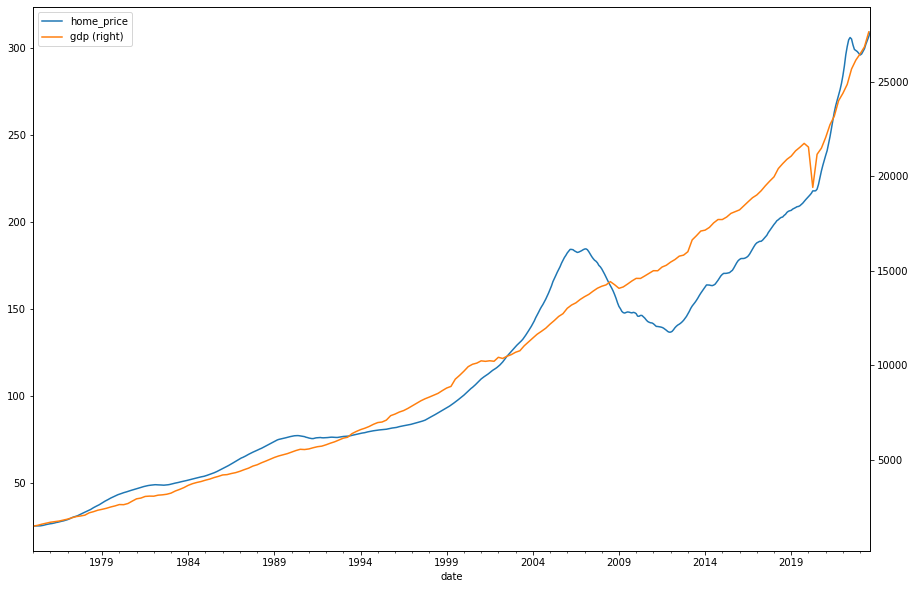

In [62]:
plt.figure(figsize=(15,10))
s_home_price.plot(legend=True)
s_gdp.plot(secondary_y=True, legend=True)
plt.show()

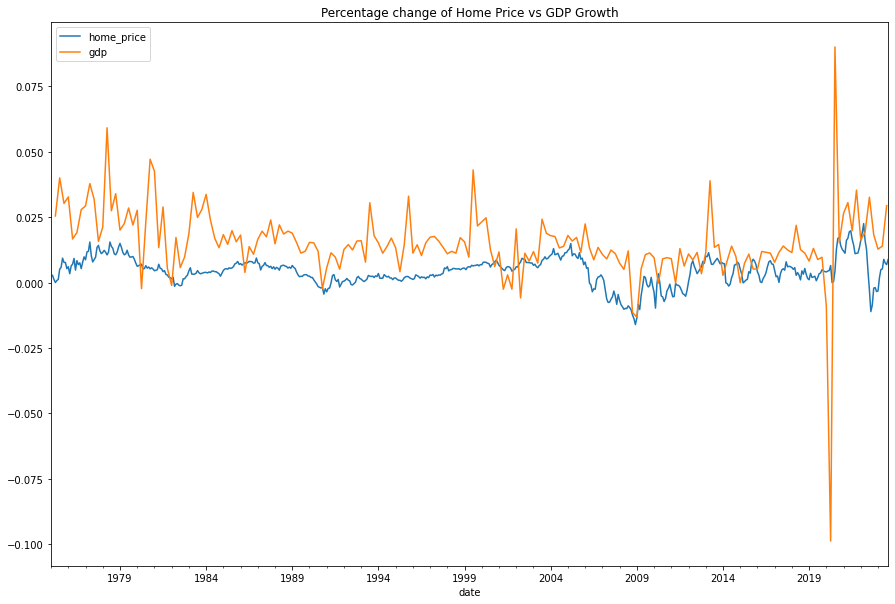

In [68]:
plt.figure(figsize=(15,10))
s_home_price.pct_change().plot(legend=True)
s_gdp.pct_change().plot(legend=True)
plt.title("Percentage change of Home Price vs GDP Growth")
plt.show()

## Interest Rates

In [59]:
s_fedrate = fred.get_series_first_release('FEDFUNDS').rename("fed_rate")
s_tbyield = fred.get_series_first_release('GS10').rename("10y_treasury")

In [60]:
s_fedrate =pd.to_numeric(s_fedrate['1975-01-01':])
s_tbyield =pd.to_numeric(s_tbyield['1975-01-01':])

In [61]:
s_fedrate.describe()

count    586.000000
mean       4.681160
std        3.961486
min        0.050000
25%        1.152500
50%        4.795000
75%        6.580000
max       19.100000
Name: fed_rate, dtype: float64

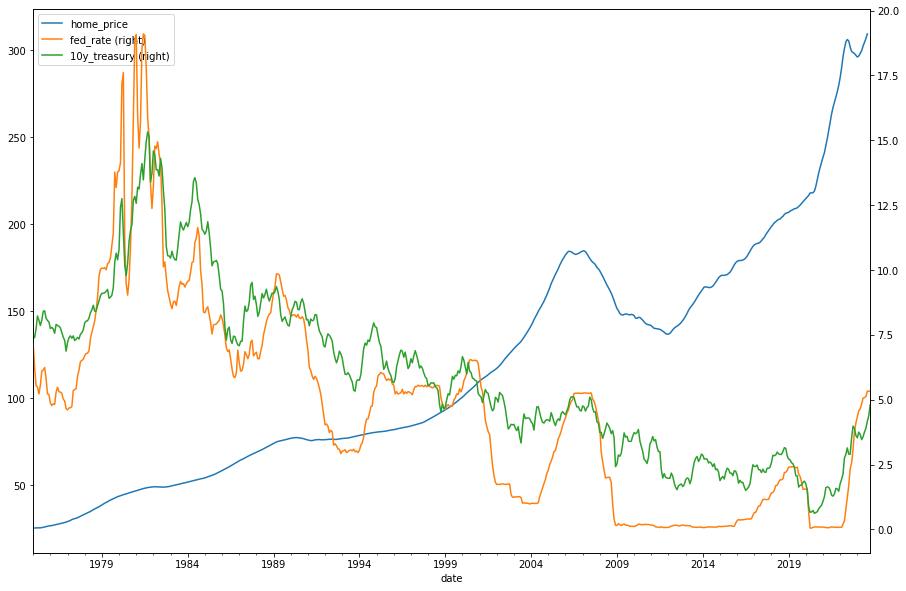

In [63]:
plt.figure(figsize=(15,10))
s_home_price.plot(legend=True)
s_fedrate.plot(secondary_y=True, legend=True)
s_tbyield.plot(secondary_y=True, legend=True)
plt.show()

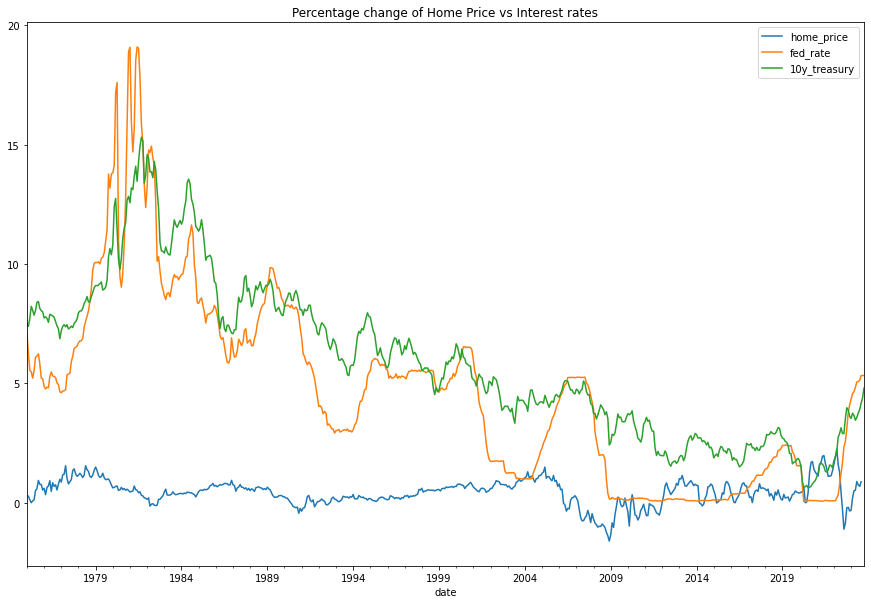

In [64]:
plt.figure(figsize=(15,10))
(100 * s_home_price.pct_change()).plot(legend=True)
s_fedrate.plot(legend=True)
s_tbyield.plot(legend=True)
plt.title("Percentage change of Home Price vs Interest rates")
plt.show()

## Mortgage rates

In [76]:
s_30mortgage = s_30mortgage['1975-01-01':]

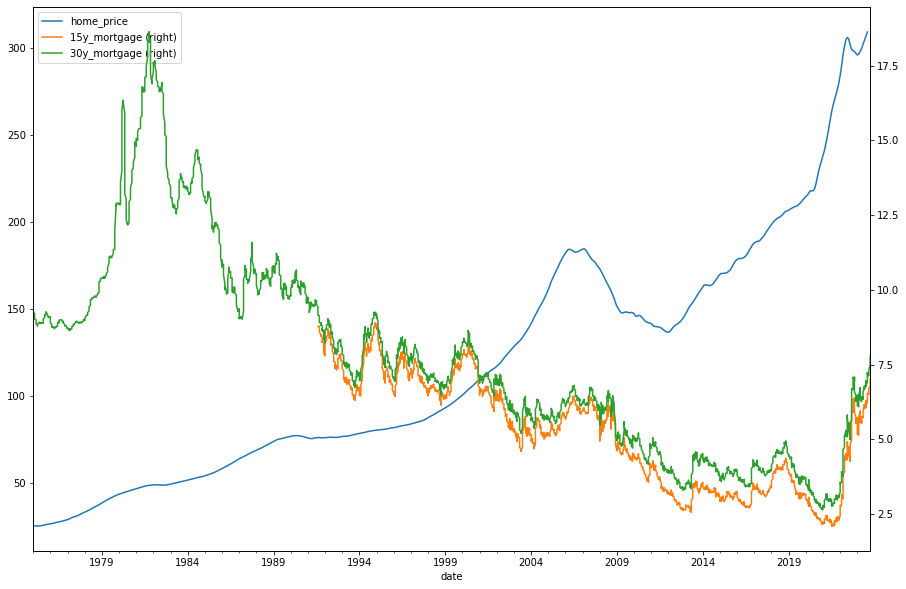

In [77]:
plt.figure(figsize=(15,10))
s_home_price.plot(legend=True)
s_15mortgage.plot(secondary_y=True, legend=True)
s_30mortgage.plot(secondary_y=True, legend=True)
plt.show()

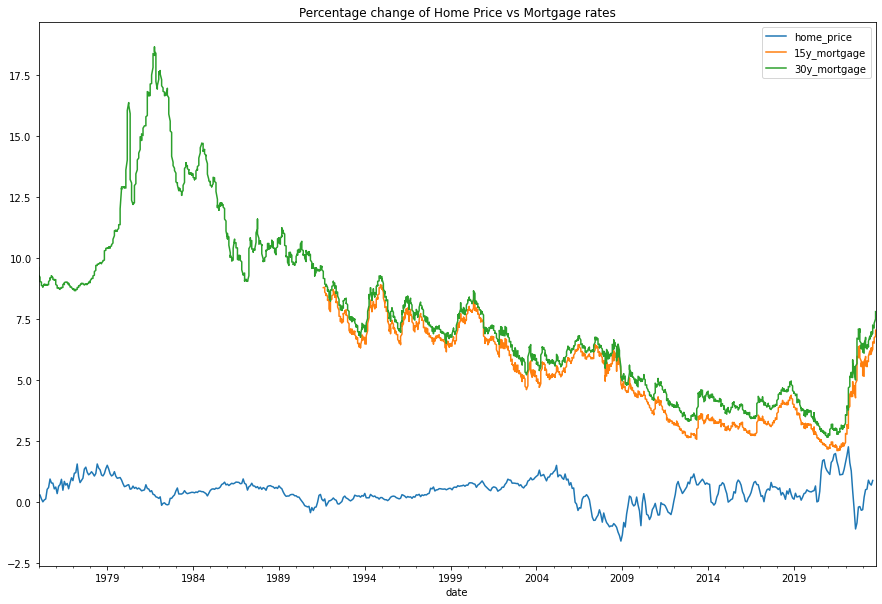

In [79]:
plt.figure(figsize=(15,10))
(100 * s_home_price.pct_change()).plot(legend=True)
s_15mortgage.plot(legend=True)
s_30mortgage.plot(legend=True)
plt.title("Percentage change of Home Price vs Mortgage rates")
plt.show()

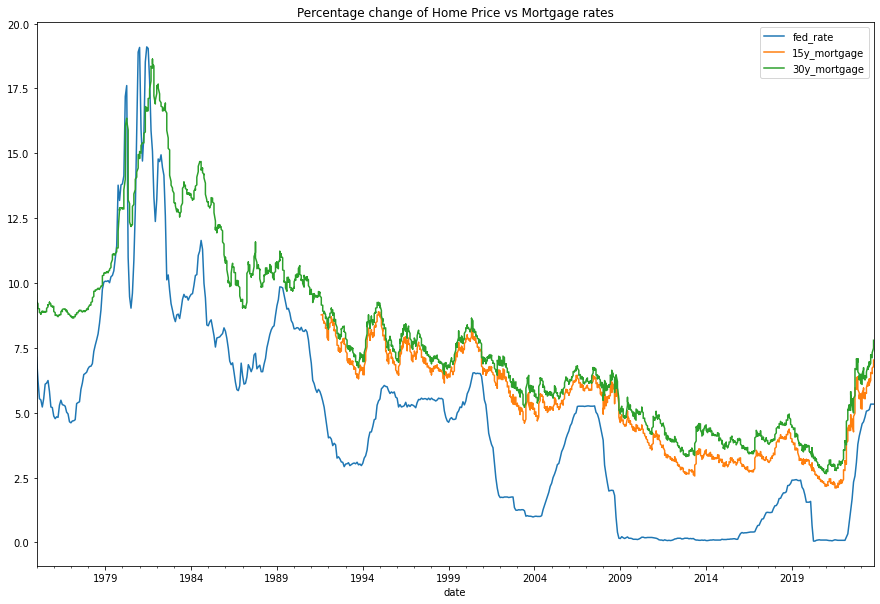

In [81]:
plt.figure(figsize=(15,10))
s_fedrate.plot(legend=True)
s_15mortgage.plot(legend=True)
s_30mortgage.plot(legend=True)
plt.title("Percentage change of Home Price vs Mortgage rates")
plt.show()

In [66]:
df_train["mortgage_30y"] = df_train["mortgage_30y"] / 100

## CPI

In [37]:
df_train["cpi"].hvplot()

:Curve   [date]   (cpi)

In [136]:
hvplot.save(df_train["cpi_less_food_energy"].hvplot(), 'cpi_less_food_energy.png')
df_train["cpi_less_food_energy"].hvplot()

:Curve   [date]   (cpi_less_food_energy)

In [137]:
df_train["inflation_less_food_energy"] = df_train["cpi_less_food_energy"].pct_change()
hvplot.save(df_train["inflation_less_food_energy"].hvplot(), 'inflation_less_food_energy.png')
df_train["inflation_less_food_energy"].hvplot()

:Curve   [date]   (inflation_less_food_energy)

## Savings

In [138]:
hvplot.save(df_train["savings"].hvplot(), 'savings.png')
df_train["savings"].hvplot()

:Curve   [date]   (savings)

In [65]:
df_train["savings"] = df_train["savings"] / 100

## unemployment

In [41]:
df_train["unemployment"].hvplot()

:Curve   [date]   (unemployment)

In [67]:
df_train["unemployment"] = df_train["unemployment"] / 100

## Population

Population is almost a upward straight line. And there seems to be data collection that causing a bump around 2002. Considering this is an unadjusted data and the difficulty of collecting population data and a very steady growth, 
it is reasonable to assume US population do not have a significant impact on home price. Thus, we will not consider population as a factor in the modeling part.

In [42]:
df_train["population"].hvplot()

:Curve   [date]   (population)

In [43]:
df_train["population"].pct_change().hvplot()

:Curve   [date]   (population)

The perfectly periodic population percentage change naturally leads to the suspicion that there are technical issues with population data collection. This is an interesting topic for future research

In [44]:
df_train["population"].pct_change()[:"2000-01-01"].hvplot()

:Curve   [date]   (population)

## Correlation Analysis

In [45]:
df_train.head()

fed_rate  treasury_10y  savings     cpi  cpi_less_food_energy  \
date                                                                        
1975-01-01      7.13          7.50      8.6  156.40                  52.3   
1975-02-01      6.24          7.39      7.8  157.40                  52.8   
1975-03-01      5.54          7.73      7.9  157.89                  53.0   
1975-04-01      5.49          8.23      9.6  158.71                  53.3   
1975-05-01      5.22          8.06     13.0  159.27                  53.5   

            unemployment  population  employment  home_price  mortgage_30y  \
date                                                                         
1975-01-01           8.2    214998.0     77295.0       25.27          9.56   
1975-02-01           8.2    215132.0     76558.0       25.34          9.29   
1975-03-01           8.7    215276.0     76353.0       25.37          9.02   
1975-04-01           8.9    215438.0     76293.0       25.37          8.86   
1975-05-01           9.2    215646.0     76443.0       25.39          8.84   

            log_price_diff  inflation_less_food_energy  
date                                                    
1975-01-01             NaN                         NaN  
1975-02-01        0.002766                    0.009560  
1975-03-01        0.001183                    0.003788  
1975-04-01        0.000000                    0.005660  
1975-05-01        0.000788                    0.003752

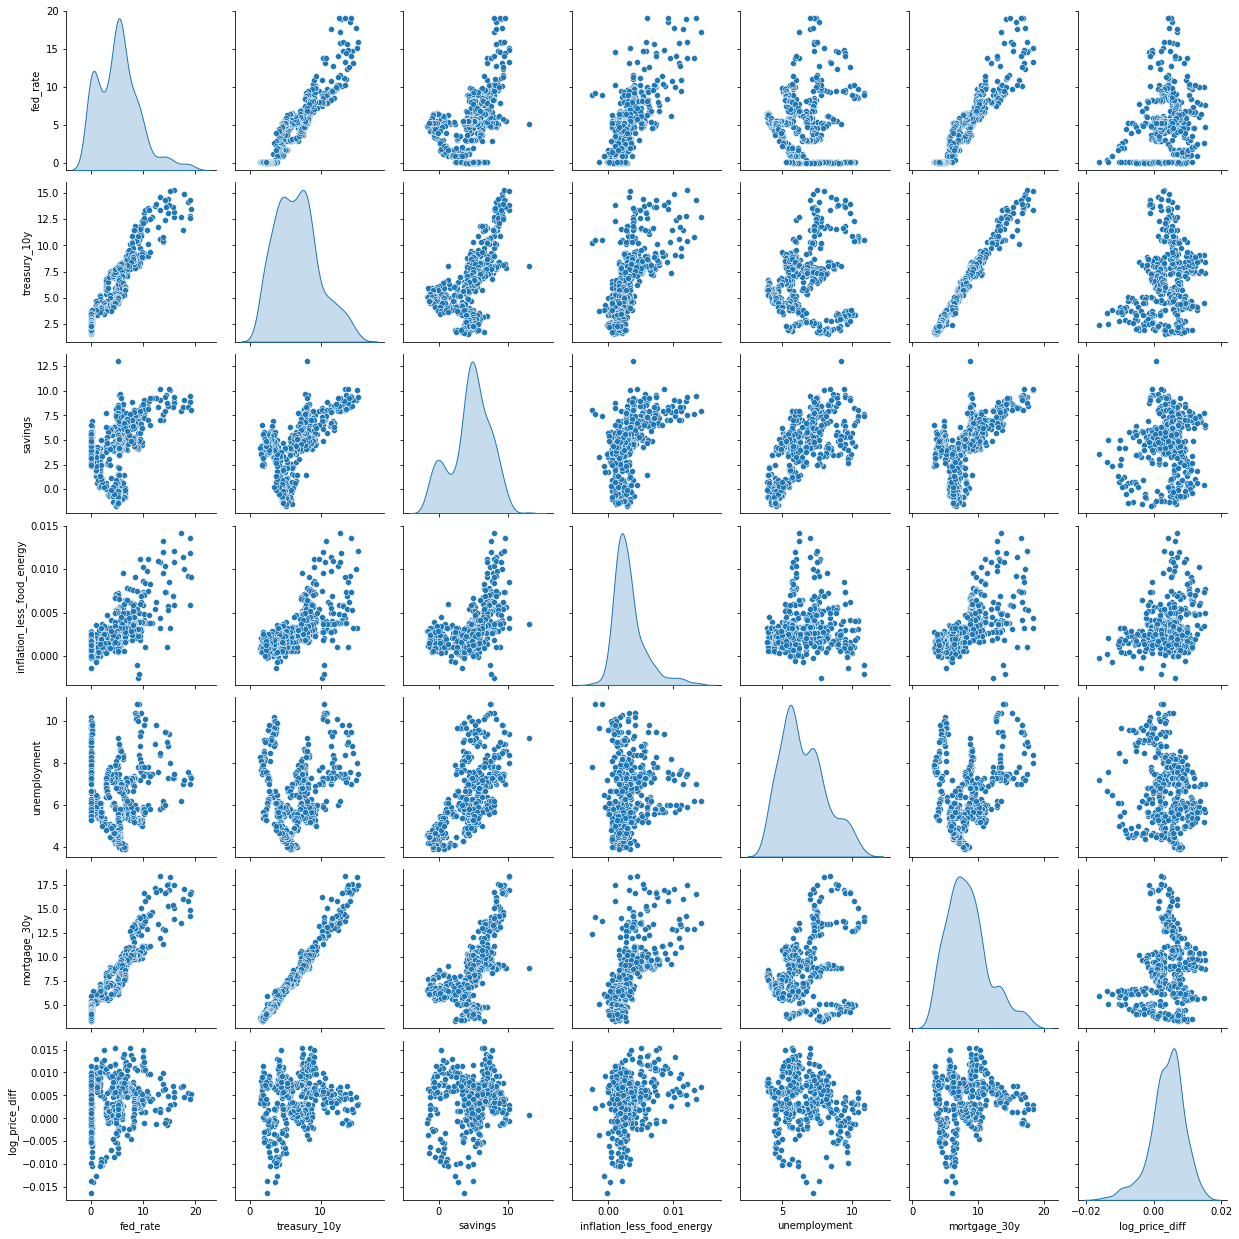

In [46]:
features = ["fed_rate", "treasury_10y", "savings", 
            "inflation_less_food_energy", "unemployment", 
            "mortgage_30y", "log_price_diff"]
sns.pairplot(df_train[features].dropna(), diag_kind="kde")

<Axes: >

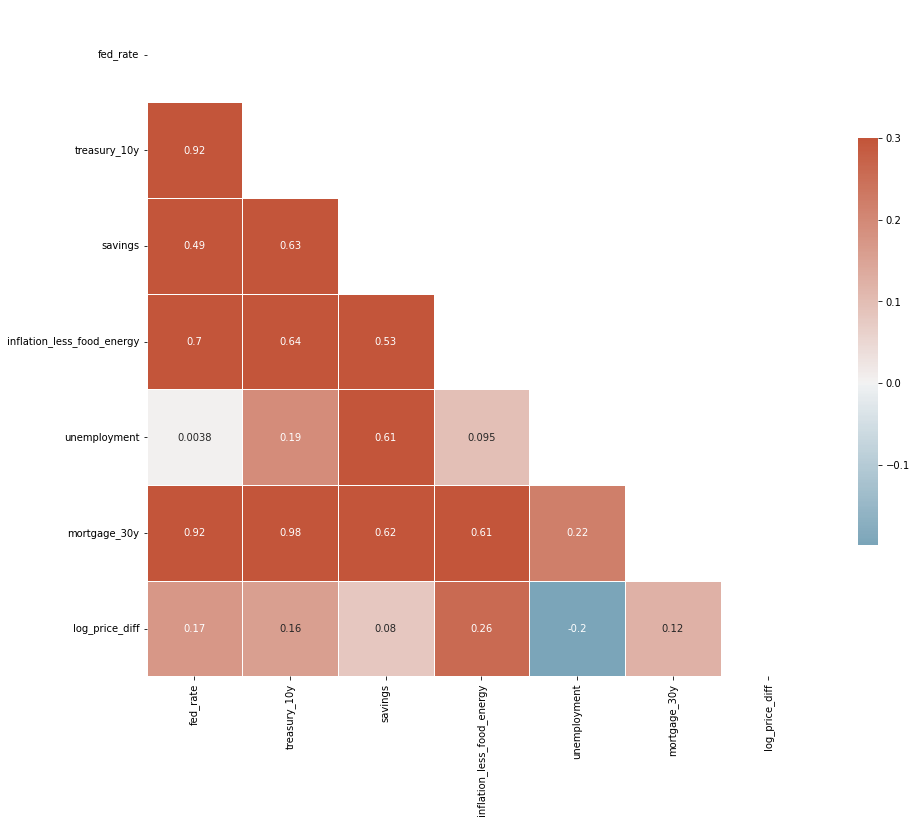

In [47]:
corr = df_train[features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, mask=mask, annot=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the pairwise plot above and correlation heatmap, we see clear linear dependence between Federal rate, 10-year treasury yield, and 30-year mortgage rate, so we only keep the mortgage rate as this is more directly related to home price and can be perceived as a manifestation of federal rates in house market

In [52]:
df_train[features].head()

fed_rate  treasury_10y  savings  inflation_less_food_energy  \
date                                                                      
1975-01-01      7.13          7.50      8.6                         NaN   
1975-02-01      6.24          7.39      7.8                    0.009560   
1975-03-01      5.54          7.73      7.9                    0.003788   
1975-04-01      5.49          8.23      9.6                    0.005660   
1975-05-01      5.22          8.06     13.0                    0.003752   

            unemployment  mortgage_30y  log_price_diff  
date                                                    
1975-01-01           8.2          9.56             NaN  
1975-02-01           8.2          9.29        0.002766  
1975-03-01           8.7          9.02        0.001183  
1975-04-01           8.9          8.86        0.000000  
1975-05-01           9.2          8.84        0.000788

# Feature Engineering

In [30]:
df.head()

fed_rate  treasury_10y  savings     cpi  cpi_less_food_energy  \
date                                                                        
1975-01-01      7.13          7.50      8.6  156.40                  52.3   
1975-02-01      6.24          7.39      7.8  157.40                  52.8   
1975-03-01      5.54          7.73      7.9  157.89                  53.0   
1975-04-01      5.49          8.23      9.6  158.71                  53.3   
1975-05-01      5.22          8.06     13.0  159.27                  53.5   

            unemployment  population  employment  home_price  mortgage_30y  
date                                                                        
1975-01-01           8.2    214998.0     77295.0       25.27          9.56  
1975-02-01           8.2    215132.0     76558.0       25.34          9.29  
1975-03-01           8.7    215276.0     76353.0       25.37          9.02  
1975-04-01           8.9    215438.0     76293.0       25.37          8.86  
1975-05-01           9.2    215646.0     76443.0       25.39          8.84

In [31]:
df["log_price_diff"] = np.log(df["home_price"]).diff()
df["inflation_less_food_energy"] = df["cpi_less_food_energy"].pct_change()
rates = ["savings", "unemployment", "mortgage_30y"]
for r in rates:
    df[r] = df[r] / 100

In [32]:
df.head()

fed_rate  treasury_10y  savings     cpi  cpi_less_food_energy  \
date                                                                        
1975-01-01      7.13          7.50    0.086  156.40                  52.3   
1975-02-01      6.24          7.39    0.078  157.40                  52.8   
1975-03-01      5.54          7.73    0.079  157.89                  53.0   
1975-04-01      5.49          8.23    0.096  158.71                  53.3   
1975-05-01      5.22          8.06    0.130  159.27                  53.5   

            unemployment  population  employment  home_price  mortgage_30y  \
date                                                                         
1975-01-01         0.082    214998.0     77295.0       25.27        0.0956   
1975-02-01         0.082    215132.0     76558.0       25.34        0.0929   
1975-03-01         0.087    215276.0     76353.0       25.37        0.0902   
1975-04-01         0.089    215438.0     76293.0       25.37        0.0886   
1975-05-01         0.092    215646.0     76443.0       25.39        0.0884   

            log_price_diff  inflation_less_food_energy  
date                                                    
1975-01-01             NaN                         NaN  
1975-02-01        0.002766                    0.009560  
1975-03-01        0.001183                    0.003788  
1975-04-01        0.000000                    0.005660  
1975-05-01        0.000788                    0.003752

In [33]:
df_train = df[:-97].copy()
df_test = df[-97:].copy()

[STALE] It could take some time for the market to process the change of these factors, so the effect on the home price index could come later. We can shift all these factors in time by 1 month

In [69]:
# columns = ["savings", "inflation_less_food_energy", "unemployment", "mortgage_30y", "log_price_diff"]
# for c in columns:
#     df_train[f"{c}_lag1"] = df_train[c].shift(1)
#     df_test[f"{c}_lag1"] = df_test[c].shift(1)

## [Stale] Time lags

From the autocorrelation plots below, we see the first four lags-correlations are significant, which suggests that we use a AR(4) to model response variable

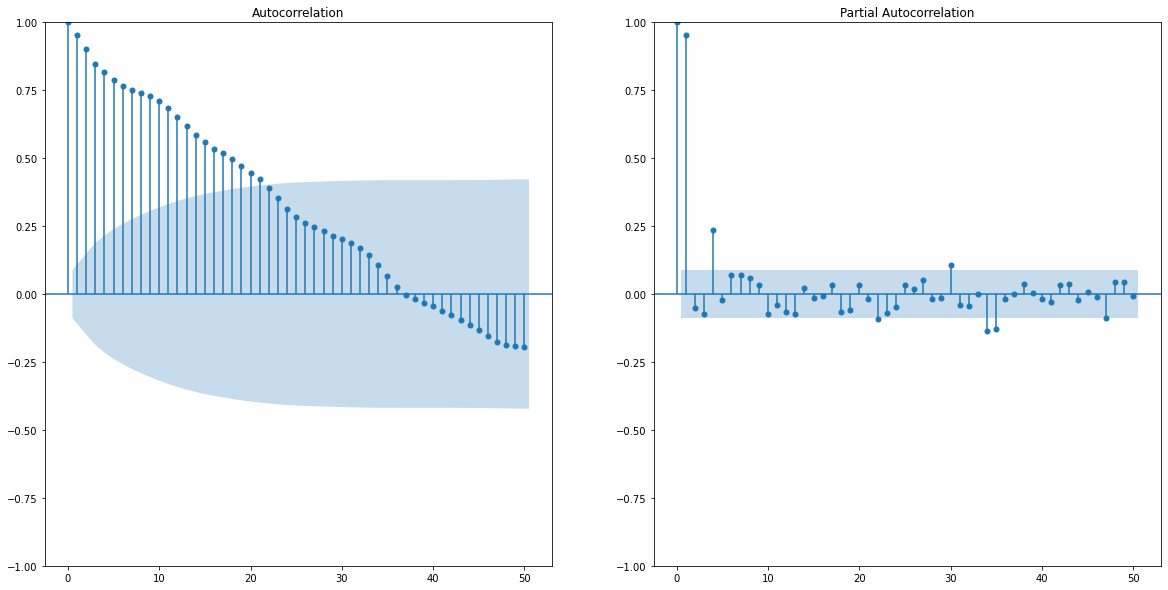

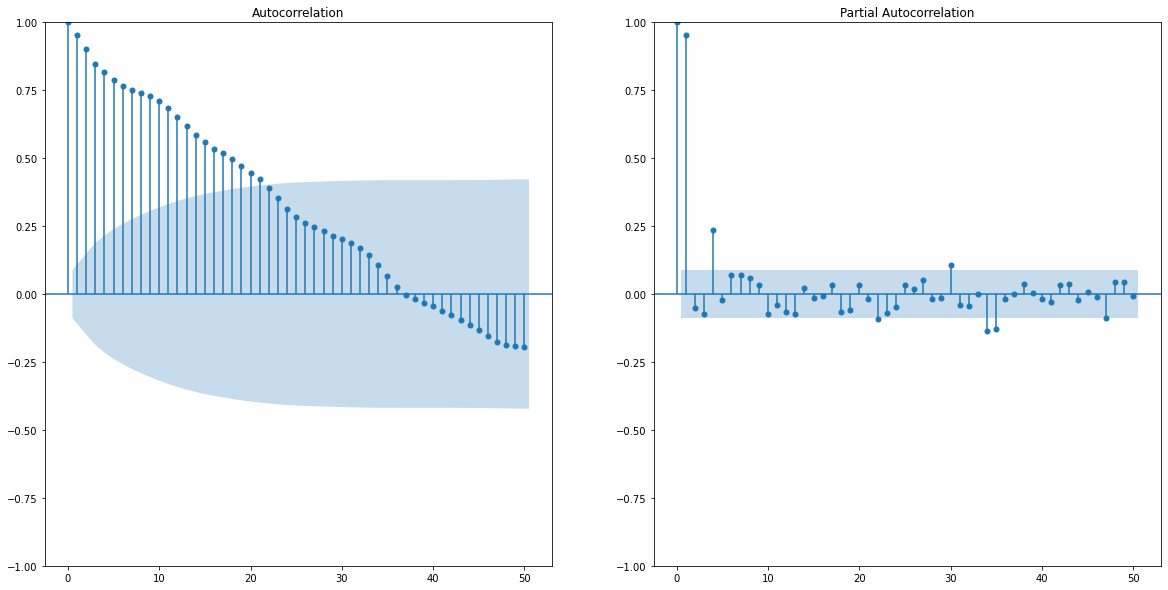

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
plot_acf(log_price_diff[1:], lags=50, ax=ax[0])
plot_pacf(log_price_diff[1:], lags=50, ax=ax[1])

In [78]:
s_home_price_df.head()

home_price   datetime  year  month  log_price_diff  \
date                                                             
1975-01-01       25.27 1975-01-01  1975      1             NaN   
1975-02-01       25.34 1975-02-01  1975      2        0.002766   
1975-03-01       25.37 1975-03-01  1975      3        0.001183   
1975-04-01       25.37 1975-04-01  1975      4        0.000000   
1975-05-01       25.39 1975-05-01  1975      5        0.000788   

            log_price_diff_pct  
date                            
1975-01-01                 NaN  
1975-02-01            0.276625  
1975-03-01            0.118320  
1975-04-01            0.000000  
1975-05-01            0.078802

In [80]:
# s_home_price_df['lpd_lag_1'] = s_home_price_df['log_price_diff'].shift(1)
# s_home_price_df['lpd_lag_2'] = s_home_price_df['log_price_diff'].shift(2)
# s_home_price_df['lpd_lag_3'] = s_home_price_df['log_price_diff'].shift(3)
# s_home_price_df['lpd_lag_4'] = s_home_price_df['log_price_diff'].shift(4)

In [80]:
for i in range(4):
    df_train[f"lpd_lag_{i+1}"] = df_train["log_price_diff"].shift(i+1)
    df_test[f"lpd_lag_{i+1}"] = df_test["log_price_diff"].shift(i+1)

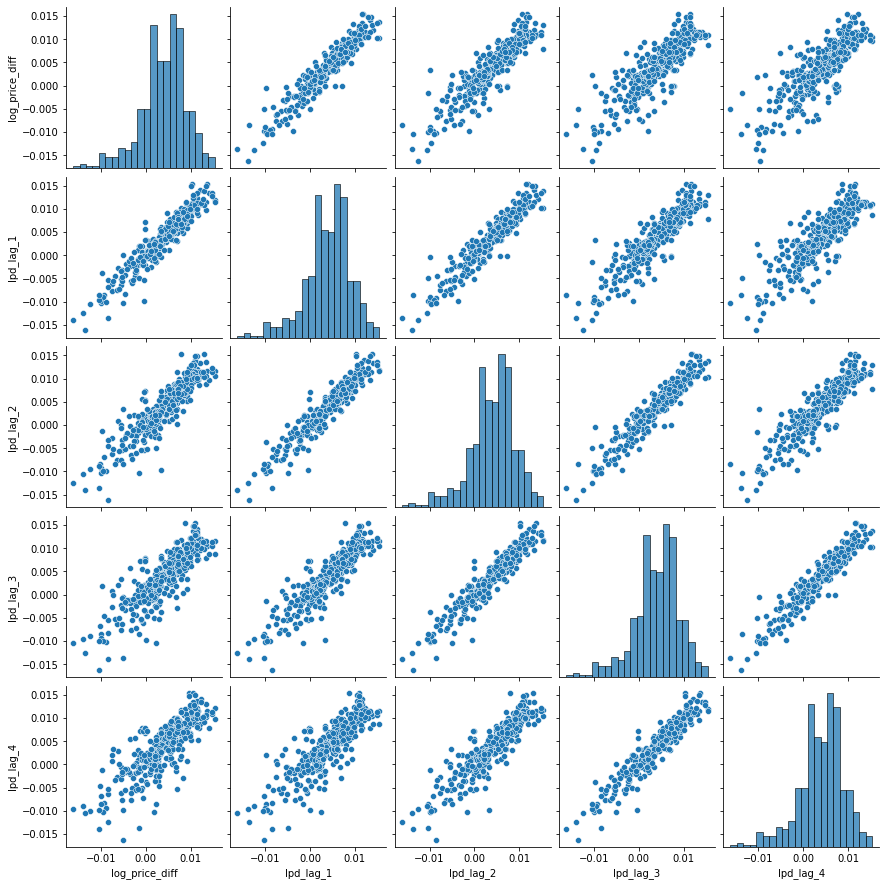

In [81]:
sns.pairplot(df_train[['log_price_diff', 'lpd_lag_1', 'lpd_lag_2', 'lpd_lag_3', 'lpd_lag_4']].dropna())

<Axes: >

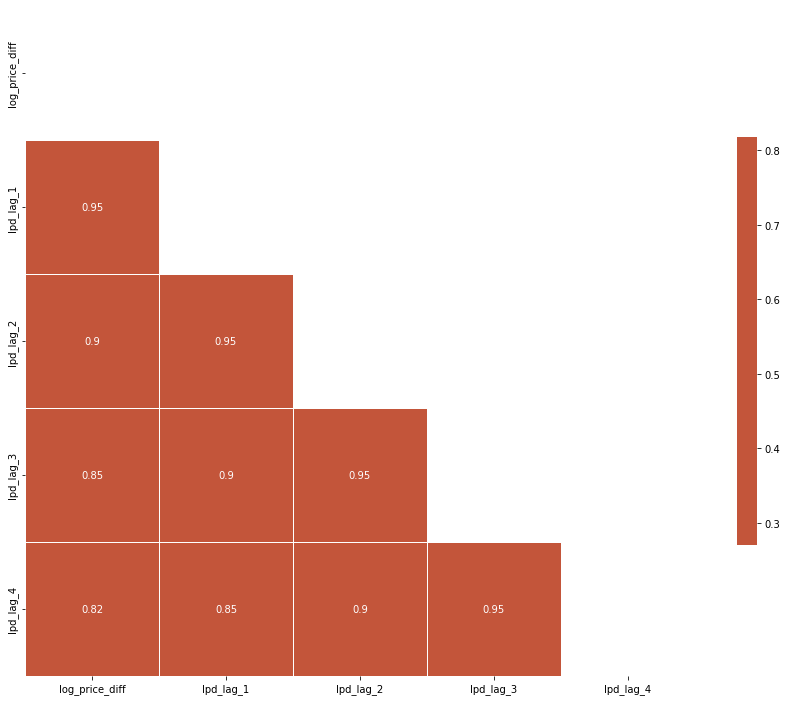

In [140]:
corr = df_train[['log_price_diff', 'lpd_lag_1', 'lpd_lag_2', 'lpd_lag_3', 'lpd_lag_4']].dropna().corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, mask=mask, annot=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Modeling

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms

## Linear Regression

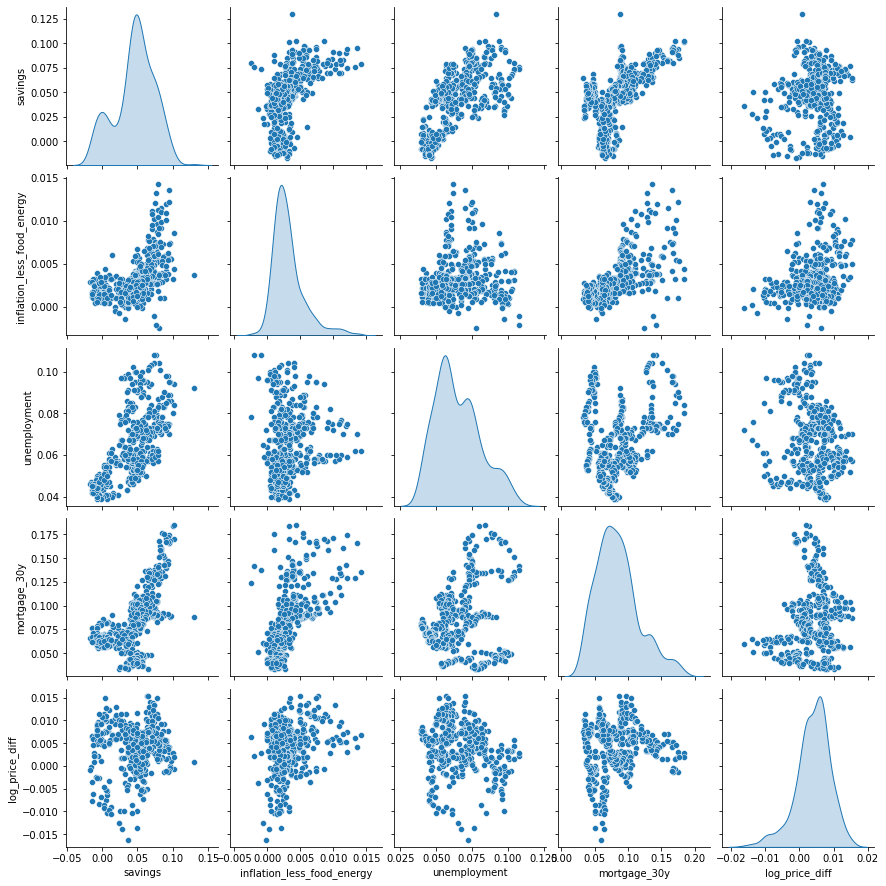

In [35]:
columns = ["savings", "inflation_less_food_energy", "unemployment", "mortgage_30y", "log_price_diff"]
sns.pairplot(df_train[columns].dropna(), diag_kind="kde")

<Axes: >

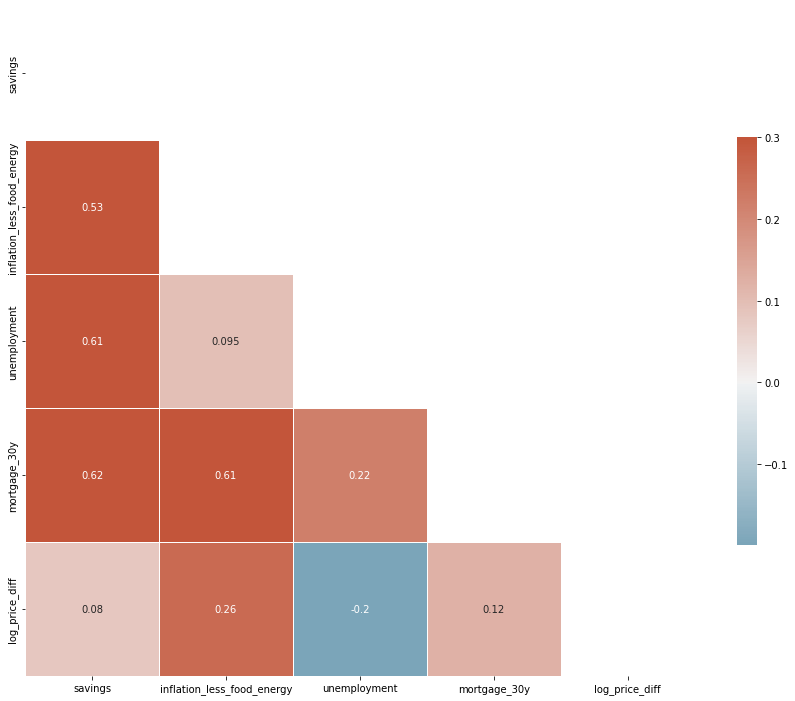

In [36]:
corr = df_train[columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, mask=mask, annot=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [42]:
formula = "log_price_diff ~ 1 + savings + inflation_less_food_energy + unemployment + mortgage_30y"
model_linear = smf.ols(formula=formula, data=df_train.iloc[1:]).fit()
print(model_linear.summary2())

                     Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.123     
Dependent Variable:    log_price_diff     AIC:                  -3818.7219
Date:                  2023-11-11 18:14   BIC:                  -3797.7908
No. Observations:      486                Log-Likelihood:       1914.4    
Df Model:              4                  F-statistic:          18.04     
Df Residuals:          481                Prob (F-statistic):   8.14e-14  
R-squared:             0.130              Scale:                2.2420e-05
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.0086   0.0012  7.3023 0.0000  0.0062  0.0109
savings                     0.0365   0.0132  2.7647 0.0059  0.0106  0.0625
inflation_less_food_energy  0.4545   0.1183  3.

Durbin Watson is very small, indicating potential autocorrelation

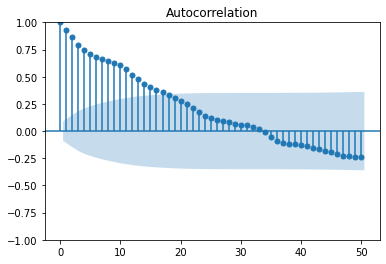

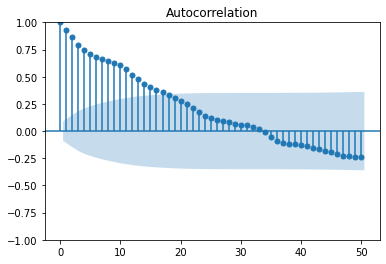

In [43]:
plot_acf(model_linear.resid, lags=50)

<Axes: >

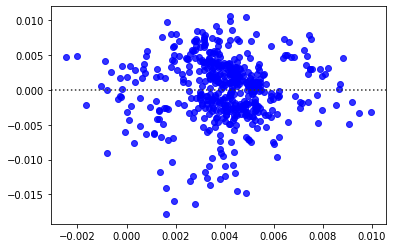

In [45]:
sns.residplot(x=model_linear.fittedvalues, y=model_linear.resid, lowess=False, color="b")

In [46]:
formula = "log_price_diff ~ savings + inflation_less_food_energy + unemployment"
model_linear = smf.ols(formula=formula, data=df_train[2:]).fit()
print(model_linear.summary2())

                     Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.123     
Dependent Variable:    log_price_diff     AIC:                  -3811.0375
Date:                  2023-11-11 18:16   BIC:                  -3794.3009
No. Observations:      485                Log-Likelihood:       1909.5    
Df Model:              3                  F-statistic:          23.73     
Df Residuals:          481                Prob (F-statistic):   2.46e-14  
R-squared:             0.129              Scale:                2.2457e-05
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.0079   0.0010  7.6313 0.0000  0.0059  0.0099
savings                     0.0302   0.0121  2.4979 0.0128  0.0064  0.0540
inflation_less_food_energy  0.4146   0.1107  3.

### Regularization

In [151]:
df_train.head()

fed_rate  treasury_10y  savings     cpi  cpi_less_food_energy  \
date                                                                        
1975-01-01      7.13          7.50    0.086  156.40                  52.3   
1975-02-01      6.24          7.39    0.078  157.40                  52.8   
1975-03-01      5.54          7.73    0.079  157.89                  53.0   
1975-04-01      5.49          8.23    0.096  158.71                  53.3   
1975-05-01      5.22          8.06    0.130  159.27                  53.5   

            unemployment  population  employment  home_price  mortgage_30y  \
date                                                                         
1975-01-01         0.082    214998.0     77295.0       25.27        0.0956   
1975-02-01         0.082    215132.0     76558.0       25.34        0.0929   
1975-03-01         0.087    215276.0     76353.0       25.37        0.0902   
1975-04-01         0.089    215438.0     76293.0       25.37        0.0886   
1975-05-01         0.092    215646.0     76443.0       25.39        0.0884   

            ...  inflation_less_food_energy  savings_lag1  \
date        ...                                             
1975-01-01  ...                         NaN           NaN   
1975-02-01  ...                    0.009560         0.086   
1975-03-01  ...                    0.003788         0.078   
1975-04-01  ...                    0.005660         0.079   
1975-05-01  ...                    0.003752         0.096   

            inflation_less_food_energy_lag1  unemployment_lag1  \
date                                                             
1975-01-01                              NaN                NaN   
1975-02-01                              NaN              0.082   
1975-03-01                         0.009560              0.082   
1975-04-01                         0.003788              0.087   
1975-05-01                         0.005660              0.089   

            mortgage_30y_lag1  log_price_diff_lag1  lpd_lag_1  lpd_lag_2  \
date                                                                       
1975-01-01                NaN                  NaN        NaN        NaN   
1975-02-01             0.0956                  NaN        NaN        NaN   
1975-03-01             0.0929             0.002766   0.002766        NaN   
1975-04-01             0.0902             0.001183   0.001183   0.002766   
1975-05-01             0.0886             0.000000   0.000000   0.001183   

            lpd_lag_3  lpd_lag_4  
date                              
1975-01-01        NaN        NaN  
1975-02-01        NaN        NaN  
1975-03-01        NaN        NaN  
1975-04-01        NaN        NaN  
1975-05-01   0.002766        NaN  

[5 rows x 21 columns]

In [159]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [162]:
X_train = df_train[["savings", "inflation_less_food_energy", "unemployment", "mortgage_30y"]].iloc[2:]
y_train = df_train["log_price_diff"].iloc[2:]
model_linear_ridge = Ridge(alpha=0.1).fit(X_train, y_train)
model_linear_ridge.coef_

array([ 0.01732984,  0.01021942, -0.04807469,  0.01215054])

In [166]:
model_linear_lasso = Lasso(alpha=0.01).fit(X_train, y_train)
model_linear_lasso.coef_

array([ 0.,  0., -0.,  0.])

### [Stale] Linear Regression with Lag 1

In [171]:
formula = "log_price_diff ~ 1 + savings + inflation_less_food_energy + unemployment + mortgage_30y + lpd_lag_1"
model_linear_lag1 = smf.ols(formula=formula, data=df_train.iloc[2:]).fit()
print(model_linear_lag1.summary2())

                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.906     
Dependent Variable:   log_price_diff     AIC:                  -4891.1466
Date:                 2023-11-11 15:08   BIC:                  -4866.0417
No. Observations:     485                Log-Likelihood:       2451.6    
Df Model:             5                  F-statistic:          932.4     
Df Residuals:         479                Prob (F-statistic):   3.41e-244 
R-squared:            0.907              Scale:                2.4121e-06
-------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------------
Intercept                   0.0003   0.0004  0.6778 0.4982 -0.0005 0.0011
savings                     0.0070   0.0044  1.6068 0.1088 -0.0016 0.0156
inflation_less_food_energy -0.0046   0.0399 -0.1162 0.9075 

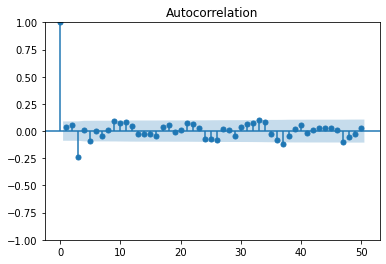

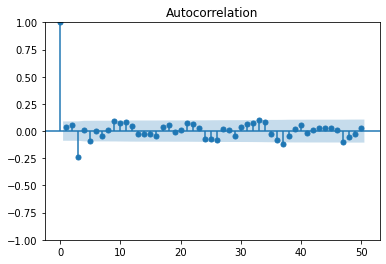

In [117]:
plot_acf(model_linear_lag1.resid, lags=50)

In [120]:
stationarity_test = adfuller(model_linear_lag1.resid)
print('ADF Statistic: %f' % stationarity_test[0])
print('p-value: %f' % stationarity_test[1])
print('Critical Values:')
for key, value in stationarity_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.432745
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


<Axes: >

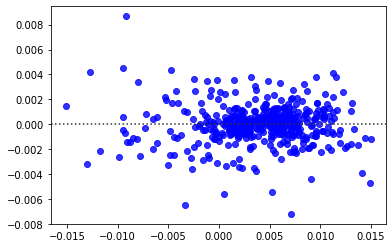

In [118]:
sns.residplot(x=model_linear_lag1.fittedvalues, y=model_linear_lag1.resid, lowess=False, color="b")

In [75]:
formula = "log_price_diff ~ 1 + inflation_less_food_energy + unemployment + mortgage_30y"
model_linear = smf.ols(formula=formula, data=df_train).fit()
print(model_linear.summary2())

                     Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.111     
Dependent Variable:    log_price_diff     AIC:                  -3813.0598
Date:                  2023-11-10 23:33   BIC:                  -3796.3150
No. Observations:      486                Log-Likelihood:       1910.5    
Df Model:              3                  F-statistic:          21.21     
Df Residuals:          482                Prob (F-statistic):   6.37e-13  
R-squared:             0.117              Scale:                2.2729e-05
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.0068   0.0010  6.8497 0.0000  0.0049  0.0088
inflation_less_food_energy  0.5714   0.1113  5.1340 0.0000  0.3527  0.7901
unemployment               -0.0723   0.0141 -5.

### [Not Used]Try regression on shifted features

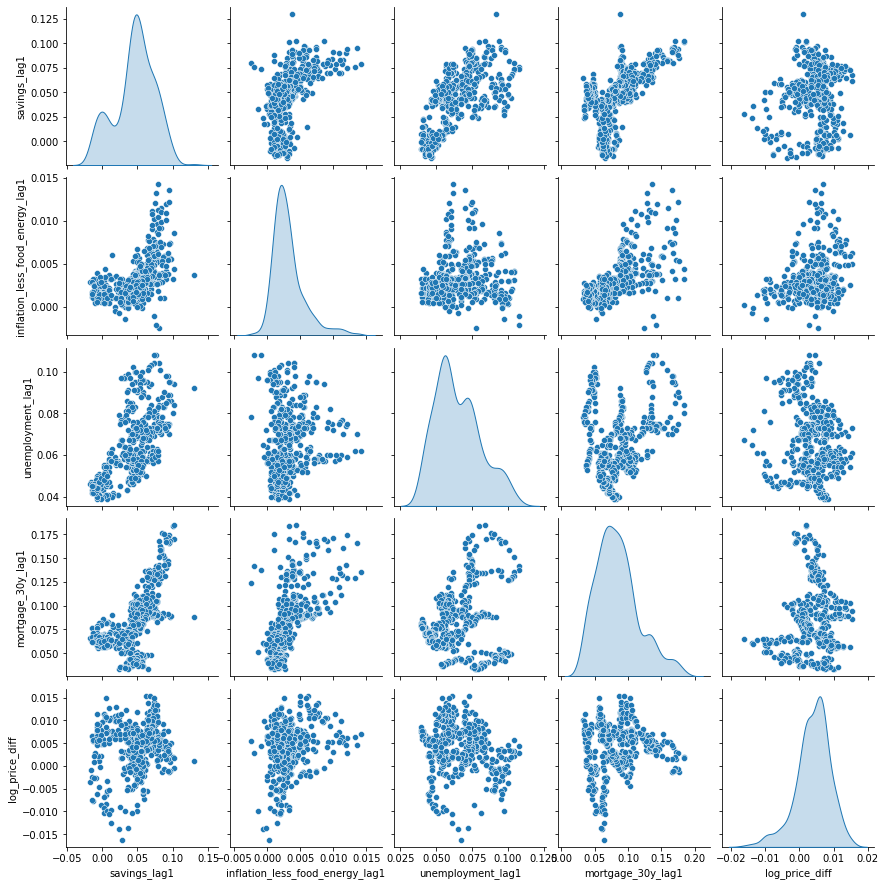

In [76]:
shifted_columns = ["savings_lag1", "inflation_less_food_energy_lag1", 
                   "unemployment_lag1", "mortgage_30y_lag1", "log_price_diff"]
sns.pairplot(df_train[shifted_columns].dropna(), diag_kind="kde")

<Axes: >

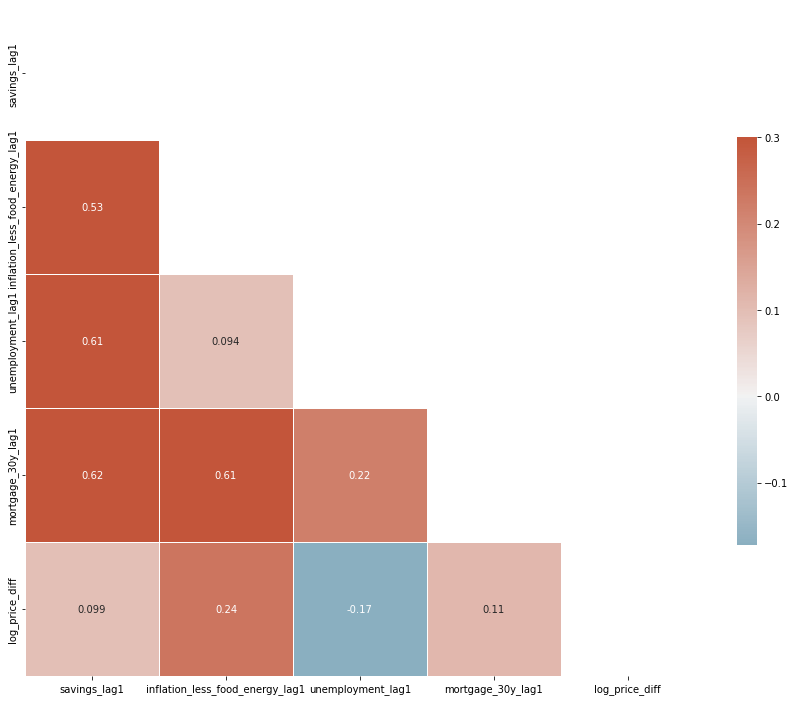

In [77]:
corr = df_train[shifted_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [78]:
formula = "log_price_diff ~ 1 + savings_lag1 + inflation_less_food_energy_lag1 + unemployment_lag1 + mortgage_30y_lag1"
model_linear_f_lag1 = smf.ols(formula=formula, data=df_train).fit()
print(model_linear_f_lag1.summary2())

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.108     
Dependent Variable:     log_price_diff       AIC:                    -3801.5611
Date:                   2023-11-10 23:34     BIC:                    -3780.6404
No. Observations:       485                  Log-Likelihood:         1905.8    
Df Model:               4                    F-statistic:            15.65     
Df Residuals:           480                  Prob (F-statistic):     4.79e-12  
R-squared:              0.115                Scale:                  2.2854e-05
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        0.0086   0.0012  7.2113 0.0000  0.0062  0.0109
savings_lag1                     0.0453   0.0134  3.3839 0.0008 

In [83]:
s_home_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 584 entries, 1975-01-01 to 2023-08-01
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   home_price            584 non-null    float64       
 1   datetime              584 non-null    datetime64[ns]
 2   year                  584 non-null    int32         
 3   month                 584 non-null    int32         
 4   log_price_diff        583 non-null    float64       
 5   log_price_diff_pct    583 non-null    float64       
 6   log_price_diff_lag_1  582 non-null    float64       
 7   log_price_diff_lag_2  581 non-null    float64       
 8   log_price_diff_lag_3  580 non-null    float64       
 9   log_price_diff_lag_4  579 non-null    float64       
 10  lpd_lag_1             582 non-null    float64       
 11  lpd_lag_2             581 non-null    float64       
 12  lpd_lag_3             580 non-null    float64       
 13  l

In [91]:
s_home_price_df = s_home_price_df.dropna()
s_home_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 579 entries, 1975-06-01 to 2023-08-01
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   home_price            579 non-null    float64       
 1   datetime              579 non-null    datetime64[ns]
 2   year                  579 non-null    int32         
 3   month                 579 non-null    int32         
 4   log_price_diff        579 non-null    float64       
 5   log_price_diff_pct    579 non-null    float64       
 6   log_price_diff_lag_1  579 non-null    float64       
 7   log_price_diff_lag_2  579 non-null    float64       
 8   log_price_diff_lag_3  579 non-null    float64       
 9   log_price_diff_lag_4  579 non-null    float64       
 10  lpd_lag_1             579 non-null    float64       
 11  lpd_lag_2             579 non-null    float64       
 12  lpd_lag_3             579 non-null    float64       
 13  l

In [92]:
df_train = s_home_price_df.iloc[:-100]
df_test = s_home_price_df.iloc[-100:]

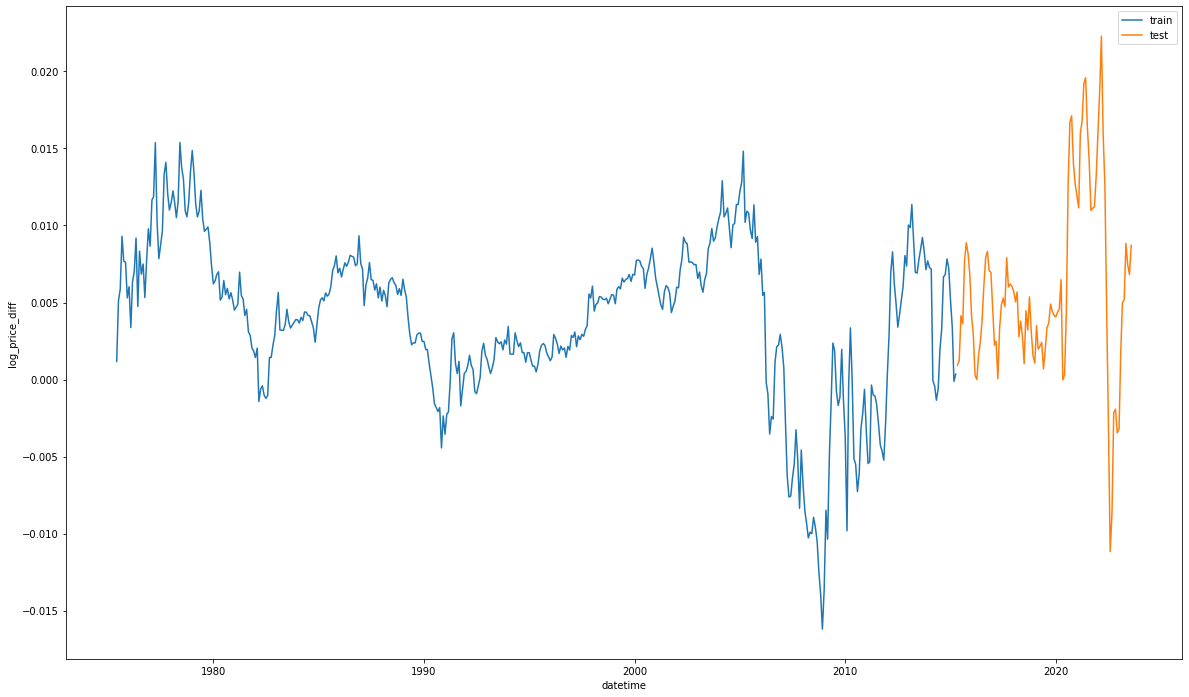

In [93]:
plt.figure(figsize=(20,12))
sns.lineplot(x='datetime', y='log_price_diff', data=df_train, label='train')
sns.lineplot(x='datetime', y='log_price_diff', data=df_test, label='test')
plt.show()

## Time Series Model

In [47]:
df_train.head()

fed_rate  treasury_10y  savings     cpi  cpi_less_food_energy  \
date                                                                        
1975-01-01      7.13          7.50    0.086  156.40                  52.3   
1975-02-01      6.24          7.39    0.078  157.40                  52.8   
1975-03-01      5.54          7.73    0.079  157.89                  53.0   
1975-04-01      5.49          8.23    0.096  158.71                  53.3   
1975-05-01      5.22          8.06    0.130  159.27                  53.5   

            unemployment  population  employment  home_price  mortgage_30y  \
date                                                                         
1975-01-01         0.082    214998.0     77295.0       25.27        0.0956   
1975-02-01         0.082    215132.0     76558.0       25.34        0.0929   
1975-03-01         0.087    215276.0     76353.0       25.37        0.0902   
1975-04-01         0.089    215438.0     76293.0       25.37        0.0886   
1975-05-01         0.092    215646.0     76443.0       25.39        0.0884   

            log_price_diff  inflation_less_food_energy  
date                                                    
1975-01-01             NaN                         NaN  
1975-02-01        0.002766                    0.009560  
1975-03-01        0.001183                    0.003788  
1975-04-01        0.000000                    0.005660  
1975-05-01        0.000788                    0.003752

In [48]:
df_test.head()

fed_rate  treasury_10y  savings      cpi  cpi_less_food_energy  \
date                                                                         
2015-08-01      0.14          2.17    0.046  237.931               242.693   
2015-09-01      0.14          2.17    0.048  237.566               243.206   
2015-10-01      0.12          2.07    0.056  238.042               243.698   
2015-11-01      0.12          2.26    0.055  238.111               244.135   
2015-12-01      0.24          2.24    0.055  237.847               244.446   

            unemployment  population  employment  home_price  mortgage_30y  \
date                                                                         
2015-08-01         0.051    321805.0    142288.0      172.32        0.0398   
2015-09-01         0.051    322030.0    142371.0      173.65        0.0384   
2015-10-01         0.050    322243.0    142654.0      175.20        0.0385   
2015-11-01         0.050    322442.0    142900.0      176.64        0.0376   
2015-12-01         0.050    322897.0    143242.0      177.85        0.0395   

            log_price_diff  inflation_less_food_energy  
date                                                    
2015-08-01        0.003604                    0.000742  
2015-09-01        0.007689                    0.002114  
2015-10-01        0.008886                    0.002023  
2015-11-01        0.008186                    0.001793  
2015-12-01        0.006827                    0.001274

In [175]:
df_train["log_price"] = np.log(df_train["home_price"])
df_test["log_price"] = np.log(df_test["home_price"])

In [49]:
endog_train = df_train["log_price_diff"].copy().iloc[1:]
exog_train = df_train[["savings", "inflation_less_food_energy", "unemployment", "mortgage_30y"]].copy().iloc[1:]
exog_train = sm.add_constant(exog_train)

endog_test = df_test["log_price_diff"].copy()
exog_test = df_test[["savings", "inflation_less_food_energy", "unemployment", "mortgage_30y"]].copy()
exo_test = sm.add_constant(exog_test)

In [50]:
exog_train.head()

const  savings  inflation_less_food_energy  unemployment  \
date                                                                   
1975-02-01    1.0    0.078                    0.009560         0.082   
1975-03-01    1.0    0.079                    0.003788         0.087   
1975-04-01    1.0    0.096                    0.005660         0.089   
1975-05-01    1.0    0.130                    0.003752         0.092   
1975-06-01    1.0    0.097                    0.005607         0.086   

            mortgage_30y  
date                      
1975-02-01        0.0929  
1975-03-01        0.0902  
1975-04-01        0.0886  
1975-05-01        0.0884  
1975-06-01        0.0889

### ARMA

In [51]:
from statsmodels.tsa.arima.model import ARIMA


In [52]:
orders = [(1,0,0), (1,0,1), (2,0,1), (2,0,2)]
models = []
for order in orders:
    model = sm.tsa.ARIMA(endog_train, exog_train, order=order, trend='n').fit()
    models.append(model)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

In [53]:
models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         log_price_diff   No. Observations:                  486
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2449.015
Date:                Sat, 11 Nov 2023   AIC                          -4884.030
Time:                        18:18:47   BIC                          -4854.727
Sample:                    02-01-1975   HQIC                         -4872.517
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0007      0.003      0.214      0.830      -0.006       0.007
savings                       -0.0030      0.008     -0.367      0.713      -0.019       0.013
inflation_less_food_energy     0.1411      0.041      3.472      0.001       0.061       0.221
unemployment                   0.0261      0.037      0.712      0.476      -0.046       0.098
mortgage_30y                   0.0027      0.028      0.098      0.922      -0.052       0.057
ar.L1                          0.9272      0.013     70.031      0.000       0.901       0.953
sigma2                      2.502e-06   1.04e-07     24.119      0.000     2.3e-06    2.71e-06
===================================================================================
Ljung-Box (L1) (Q):                   2.56   Jarque-Bera (JB):               265.53
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
features = ["savings", "inflation_less_food_energy", "unemployment"]
exog_train[features].head()

savings  inflation_less_food_energy  unemployment
date                                                         
1975-02-01    0.078                    0.009560         0.082
1975-03-01    0.079                    0.003788         0.087
1975-04-01    0.096                    0.005660         0.089
1975-05-01    0.130                    0.003752         0.092
1975-06-01    0.097                    0.005607         0.086

In [58]:
features = ["savings", "inflation_less_food_energy", "unemployment"]
orders = [(1,0,0), (1,0,1), (2,0,1), (2,0,2)]
models_1 = []
for order in orders:
    model = sm.tsa.ARIMA(endog_train, exog_train[features], order=order, trend='n').fit()
    models_1.append(model)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

In [59]:
models_1[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         log_price_diff   No. Observations:                  486
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2340.385
Date:                Sat, 11 Nov 2023   AIC                          -4670.770
Time:                        18:20:51   BIC                          -4649.839
Sample:                    02-01-1975   HQIC                         -4662.547
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
savings                       -0.0091      0.010     -0.901      0.367      -0.029       0.011
inflation_less_food_energy     0.7501      0.031     24.483      0.000       0.690       0.810
unemployment                   0.0253      0.016      1.584      0.113      -0.006       0.057
ar.L1                          0.9191      0.017     54.589      0.000       0.886       0.952
sigma2                      3.826e-06   2.23e-07     17.126      0.000    3.39e-06    4.26e-06
===================================================================================
Ljung-Box (L1) (Q):                   4.99   Jarque-Bera (JB):               206.18
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.13
Prob(H) (two-sided):                  0.91   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
models_1[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         log_price_diff   No. Observations:                  486
Model:                 ARIMA(2, 0, 2)   Log Likelihood                2447.369
Date:                Sat, 11 Nov 2023   AIC                          -4878.738
Time:                        18:22:49   BIC                          -4845.248
Sample:                    02-01-1975   HQIC                         -4865.581
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
savings                       -0.0027      0.008     -0.337      0.736      -0.019       0.013
inflation_less_food_energy     0.0495      0.049      1.015      0.310      -0.046       0.145
unemployment                   0.0409      0.013      3.075      0.002       0.015       0.067
ar.L1                          1.1900      1.193      0.998      0.318      -1.148       3.528
ar.L2                         -0.2383      1.111     -0.214      0.830      -2.416       1.939
ma.L1                         -0.3256      1.198     -0.272      0.786      -2.674       2.023
ma.L2                         -0.0151      0.099     -0.152      0.879      -0.209       0.179
sigma2                      2.451e-06   1.02e-07     24.008      0.000    2.25e-06    2.65e-06
===================================================================================
Ljung-Box (L1) (Q):                   9.42   Jarque-Bera (JB):               233.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
model_arma_inflation_only = sm.tsa.ARIMA(endog_train, exog_train[["inflation_less_food_energy"]], order=(1,0,0), trend='n').fit()
model_arma_inflation_only.summary()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         log_price_diff   No. Observations:                  486
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2280.579
Date:                Sat, 11 Nov 2023   AIC                          -4555.158
Time:                        18:24:29   BIC                          -4542.599
Sample:                    02-01-1975   HQIC                         -4550.224
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflation_less_food_energy     0.9762      0.040     24.485      0.000       0.898       1.054
ar.L1                          0.8986      0.019     46.594      0.000       0.861       0.936
sigma2                      4.893e-06   3.38e-07     14.476      0.000    4.23e-06    5.55e-06
===================================================================================
Ljung-Box (L1) (Q):                  11.39   Jarque-Bera (JB):               305.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.25
Prob(H) (two-sided):                  0.09   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA

In [113]:
features = ["savings", "inflation_less_food_energy", "unemployment"]
orders = [(0,2,0)]
models_2 = []
for order in orders:
    model = sm.tsa.ARIMA(endog_train, exog_train[features], order=order, trend='n').fit()
    models_2.append(model)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters f

### No exogeneous variable

In [33]:
orders = [(0,2,0), (1,2,0), (2,2,0), (0,2,1), (1,2,1), (2,2,1), (2,2,2)]
models_3 = []
for order in orders:
    model = sm.tsa.ARIMA(df_train["home_price"], order=order, trend='n').fit()
    models_3.append(model)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [47]:
model = sm.tsa.ARIMA(df_train["home_price"], order=(0,2,2), trend='n').fit()
models_3.append(model)

In [49]:
models_3[6].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             home_price   No. Observations:                  487
Model:                 ARIMA(2, 2, 2)   Log Likelihood                  93.917
Date:                Mon, 13 Nov 2023   AIC                           -177.835
Time:                        14:23:31   BIC                           -156.914
Sample:                    01-01-1975   HQIC                          -169.615
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0158      0.102     -9.930      0.000      -1.216      -0.815
ar.L2         -0.3126      0.112     -2.788      0.005      -0.532      -0.093
ma.L1          1.1318      0.096     11.766      0.000       0.943       1.320
ma.L2          0.5095      0.107      4.756      0.000       0.300       0.719
sigma2         0.0397      0.001     35.794      0.000       0.038       0.042
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2392.28
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              39.66   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Model Selection and Validation

# Model Assessment

In [68]:
X_test = df_test[["savings", "inflation_less_food_energy", "unemployment", "mortgage_30y"]]
y_gt = df_test.loc[X_test.index, "log_price_diff"]

In [69]:
X_test.head()

savings  inflation_less_food_energy  unemployment  mortgage_30y
date                                                                       
2015-08-01    0.046                    0.000742         0.051        0.0398
2015-09-01    0.048                    0.002114         0.051        0.0384
2015-10-01    0.056                    0.002023         0.050        0.0385
2015-11-01    0.055                    0.001793         0.050        0.0376
2015-12-01    0.055                    0.001274         0.050        0.0395

In [70]:
y_gt.head()

date
2015-08-01    0.003604
2015-09-01    0.007689
2015-10-01    0.008886
2015-11-01    0.008186
2015-12-01    0.006827
Freq: MS, Name: log_price_diff, dtype: float64

## Linear Model

In [71]:
model_linear.params

Intercept                     0.007886
savings                       0.030204
inflation_less_food_energy    0.414577
unemployment                 -0.102096
dtype: float64

In [102]:
y_pred = model_linear.predict(X_test)

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

rmse = lambda gt, pred: np.sqrt(mean_squared_error(gt, pred))

print("RMSE by Linear model: ", rmse(y_gt, y_pred))
print("MAE by Linear model: ", mean_absolute_error(y_gt, y_pred))

RMSE by Linear model:  0.005821670837496612
MAE by Linear model:  0.004505345405253412


Transform the predictions to the price range

In [104]:
start_price = df_train["home_price"].iloc[-1]
y_price_gt = df_test.loc[X_test.index, "home_price"]
y_price_pred = np.exp(y_pred.cumsum() + np.log(start_price))

print("Price RMSE by Linear Model: ", rmse(y_price_gt, y_price_pred))
print("Price MAE by Linear Model: ", mean_absolute_error(y_price_gt, y_price_pred))

Price RMSE by Linear Model:  11.080318094419948
Price MPAE by Linear Model:  8.37026752237061


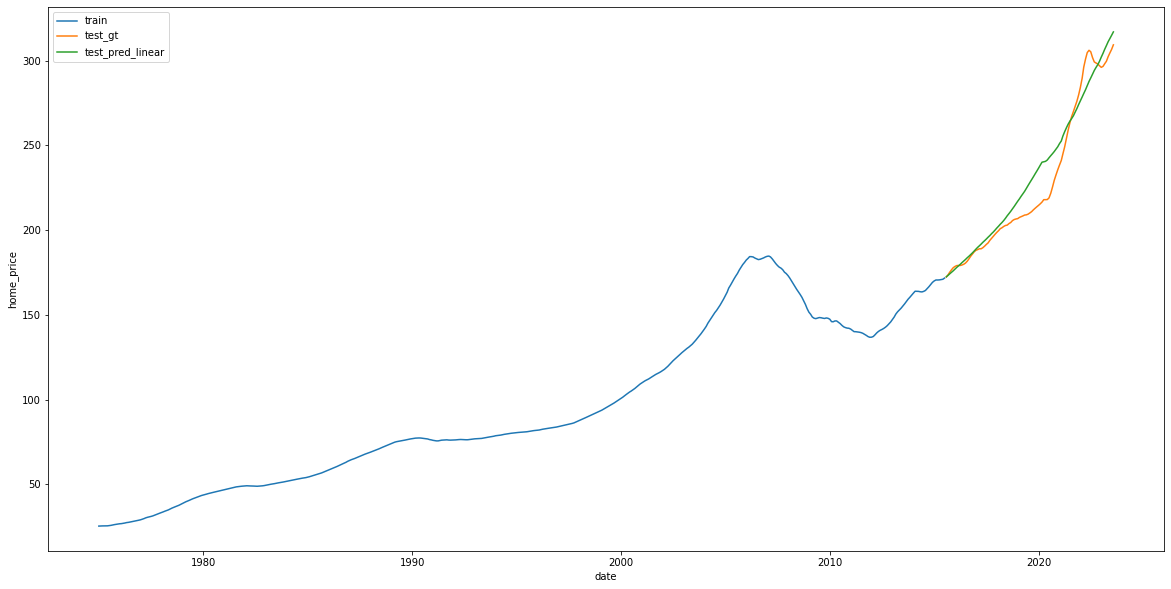

In [91]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='home_price', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='home_price', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='home_price_pred', data=y_price_pred.to_frame(name="home_price_pred"), label='test_pred_linear', ax=ax)
plt.show()

<Axes: xlabel='date', ylabel='log_price_diff'>

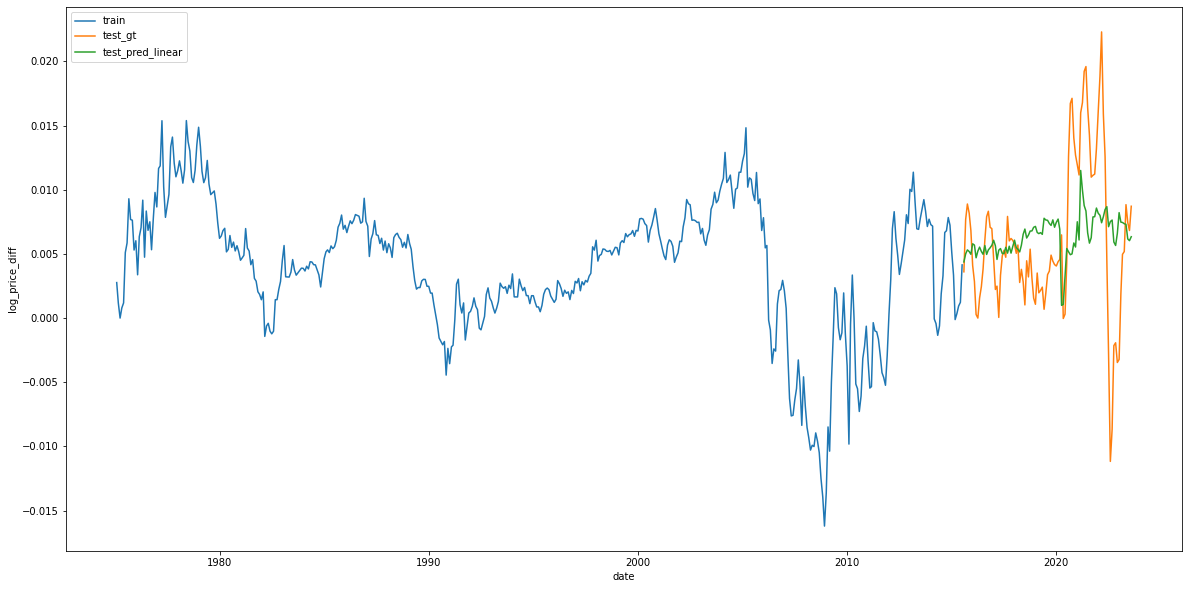

In [92]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='log_price_diff', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='log_price_diff', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='log_price_difference_pred', data=y_pred.to_frame(name="log_price_difference_pred"), label='test_pred_linear', ax=ax)

## ARMA Model

In [77]:
model_arma = models[0]
model_arma.params

const                         0.000714
savings                      -0.002997
inflation_less_food_energy    0.141060
unemployment                  0.026101
mortgage_30y                  0.002728
ar.L1                         0.927235
sigma2                        0.000003
dtype: float64

In [78]:
exo_test.tail()

const  savings  inflation_less_food_energy  unemployment  \
date                                                                   
2023-04-01    1.0    0.041                    0.004092         0.034   
2023-05-01    1.0    0.046                    0.004356         0.037   
2023-06-01    1.0    0.043                    0.001576         0.036   
2023-07-01    1.0    0.035                    0.001596         0.035   
2023-08-01    1.0    0.039                    0.002785         0.038   

            mortgage_30y  
date                      
2023-04-01        0.0632  
2023-05-01        0.0643  
2023-06-01        0.0679  
2023-07-01        0.0671  
2023-08-01        0.0681

In [105]:
y_pred = model_arma.predict(exog=exo_test, start=len(exog_train), end = len(exog_train) + len(exog_test)-1)
y_pred.index.name = "date"

In [106]:
rmse = lambda gt, pred: np.sqrt(mean_squared_error(gt, pred))

print("RMSE by Linear model: ", rmse(y_gt, y_pred))
print("MAE by Linear model: ", mean_absolute_error(y_gt, y_pred))

RMSE by Linear model:  0.006979574637923666
MPAE by Linear model:  0.005107331578427198


<Axes: xlabel='date', ylabel='log_price_diff'>

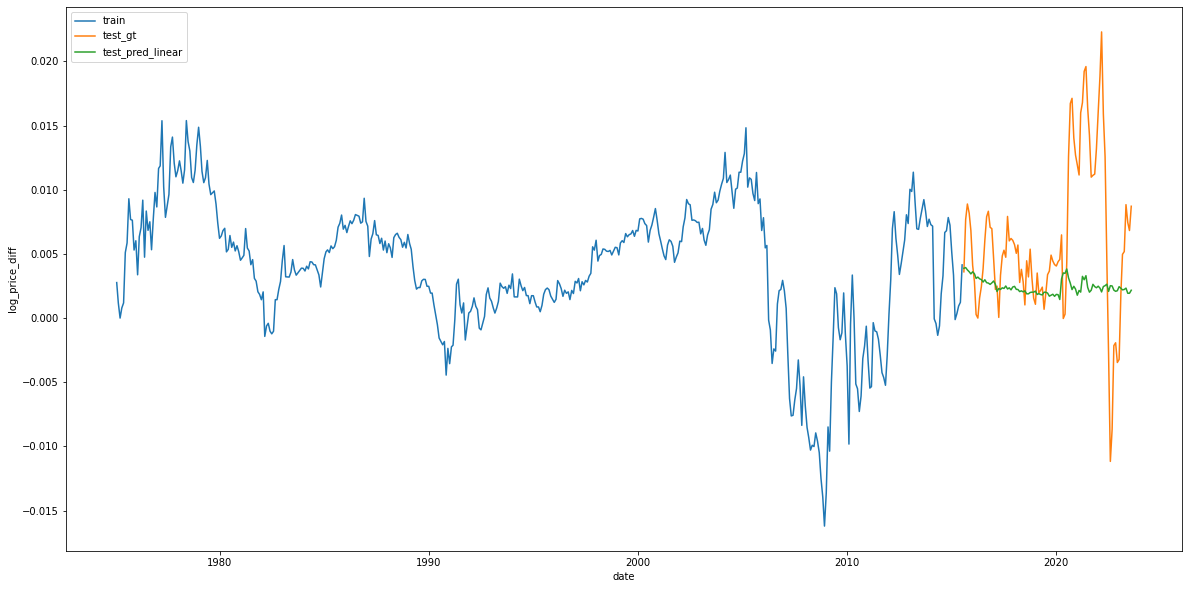

In [96]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='log_price_diff', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='log_price_diff', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='log_price_difference_pred', data=y_pred.to_frame(name="log_price_difference_pred"), label='test_pred_linear', ax=ax)

Price RMSE by Linear Model:  45.47537146563884
Price MPAE by Linear Model:  32.51562579324914


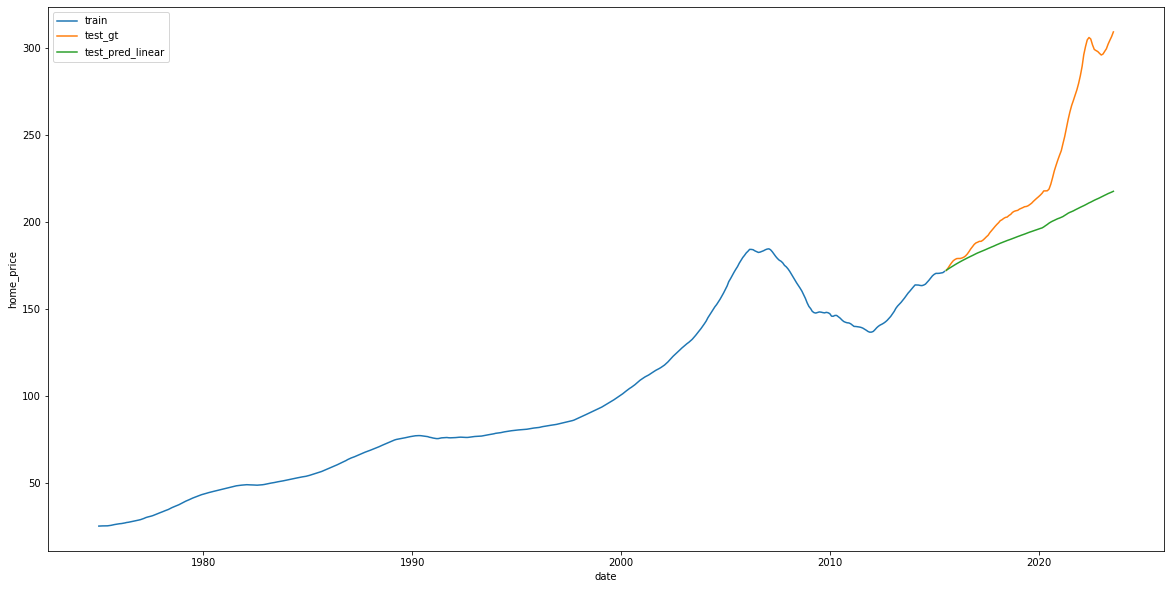

In [107]:
start_price = df_train["home_price"].iloc[-1]
y_price_gt = df_test.loc[X_test.index, "home_price"]
y_price_pred = np.exp(y_pred.cumsum() + np.log(start_price))
print("Price RMSE by Linear Model: ", rmse(y_price_gt, y_price_pred))
print("Price MAE by Linear Model: ", mean_absolute_error(y_price_gt, y_price_pred))

fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='home_price', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='home_price', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='home_price_pred', data=y_price_pred.to_frame(name="home_price_pred"), label='test_pred_linear', ax=ax)
plt.show()

Excluding mortgage rates

In [87]:
model_arma_exclude_mortgage = models_1[0]
model_arma_exclude_mortgage.params

savings                      -0.009138
inflation_less_food_energy    0.750134
unemployment                  0.025278
ar.L1                         0.919132
sigma2                        0.000004
dtype: float64

In [108]:
y_pred = model_arma_exclude_mortgage.predict(exog=exo_test[features], start=len(exog_train), end = len(exog_train) + len(exog_test)-1)
y_pred.index.name = "date"

RMSE by Linear model:  0.0068253996627003705
MPAE by Linear model:  0.005098868206203643


<Axes: xlabel='date', ylabel='log_price_diff'>

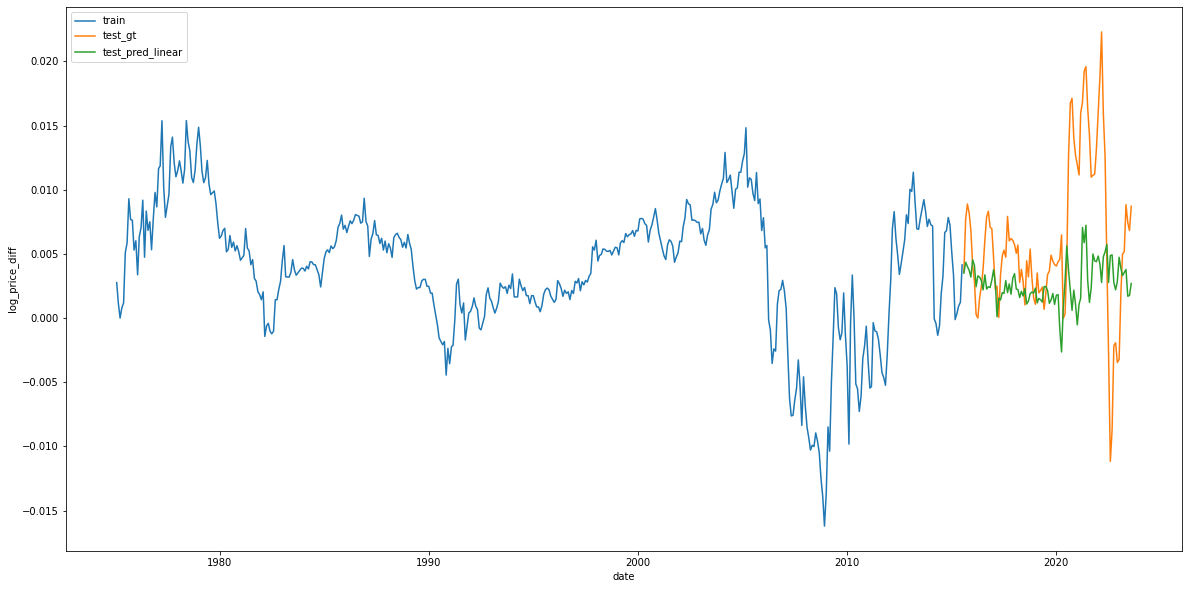

In [109]:
rmse = lambda gt, pred: np.sqrt(mean_squared_error(gt, pred))
print("RMSE by Linear model: ", rmse(y_gt, y_pred))
print("MAE by Linear model: ", mean_absolute_error(y_gt, y_pred))

fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='log_price_diff', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='log_price_diff', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='log_price_difference_pred', data=y_pred.to_frame(name="log_price_difference_pred"), label='test_pred_linear', ax=ax)

Price RMSE by Linear Model:  45.076259834736724
Price MPAE by Linear Model:  32.82437568242623


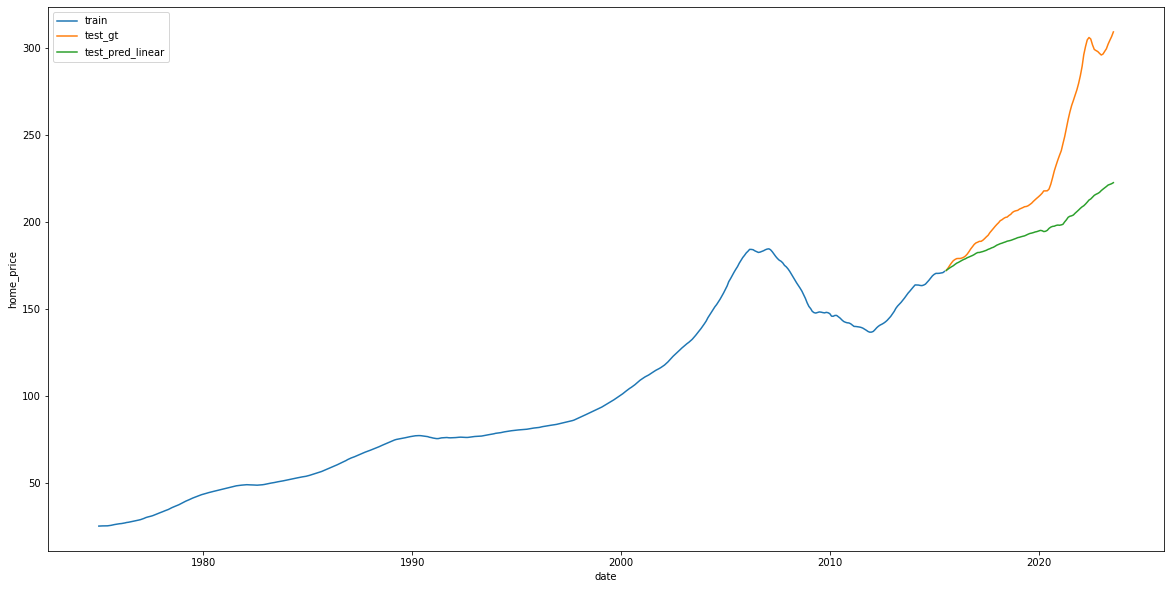

In [110]:
start_price = df_train["home_price"].iloc[-1]
y_price_gt = df_test.loc[X_test.index, "home_price"]
y_price_pred = np.exp(y_pred.cumsum() + np.log(start_price))
print("Price RMSE by Linear Model: ", rmse(y_price_gt, y_price_pred))
print("Price MAE by Linear Model: ", mean_absolute_error(y_price_gt, y_price_pred))

fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='home_price', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='home_price', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='home_price_pred', data=y_price_pred.to_frame(name="home_price_pred"), label='test_pred_linear', ax=ax)
plt.show()

## Plain ARIMA model

In [77]:
y_price_pred = models_3[7].predict(start=len(df_train), end = len(df_train) + len(df_test)-1)
y_price_pred.index.name = "date"

In [78]:
y_price_pred.head()

date
2015-08-01    172.471630
2015-09-01    173.293999
2015-10-01    174.116367
2015-11-01    174.938735
2015-12-01    175.761103
Freq: MS, Name: predicted_mean, dtype: float64

Price RMSE by Linear Model:  27.94524198177627
Price MPAE by Linear Model:  16.272312875167


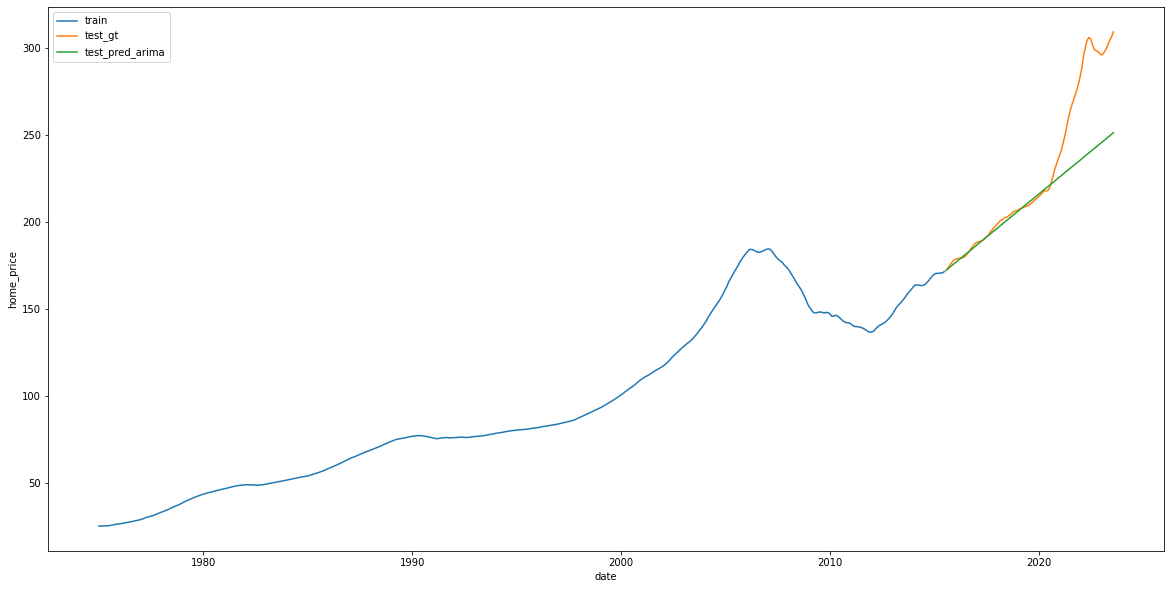

In [79]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
rmse = lambda gt, pred: np.sqrt(mean_squared_error(gt, pred))

y_price_gt = df_test["home_price"]
print("Price RMSE by Linear Model: ", rmse(y_price_gt, y_price_pred))
print("Price MAE by Linear Model: ", mean_absolute_error(y_price_gt, y_price_pred))

fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='home_price', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='home_price', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='home_price_pred', data=y_price_pred.to_frame(name="home_price_pred"), label='test_pred_arima', ax=ax)
plt.show()

## AR(1) with external features

In [88]:
model_linear_lag1.params 

Intercept                     0.000275
savings                       0.007005
inflation_less_food_energy   -0.004639
unemployment                 -0.000334
mortgage_30y                 -0.004426
lpd_lag_1                     0.953427
dtype: float64

In [96]:
y_pred = model_linear_lag1.predict(X_test)

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = lambda gt, pred: np.sqrt(mean_squared_error(gt, pred))

print("RMSE by AR(1) model: ", rmse(y_gt, y_pred))
print("MPAE by AR(1) model: ", mean_absolute_percentage_error(y_gt, y_pred))

RMSE by AR(1) model:  0.0027089549272103193
MPAE by AR(1) model:  34587125832.67702


Transform the value to price range

In [99]:
df_test["lpd_lag_1"].head()

date
2015-08-01         NaN
2015-09-01         NaN
2015-10-01    0.007689
2015-11-01    0.008886
2015-12-01    0.008186
Freq: MS, Name: lpd_lag_1, dtype: float64

In [101]:
start_price = df_test["home_price"].iloc[1]
y_price_gt = df_test.loc[X_test.index, "home_price"]
y_price_pred = np.exp(y_pred.cumsum() + np.log(start_price))

In [102]:
print("Price RMSE by AR(1) model: ", rmse(y_price_gt, y_price_pred))
print("Price MPAE by AR(1) model: ", mean_absolute_percentage_error(y_price_gt, y_price_pred))

Price RMSE by AR(1) model:  5.376099237253284
Price MPAE by AR(1) model:  0.01684490149242393


In [103]:
y_price_pred.head()

date
2015-10-01    175.010008
2015-11-01    176.581872
2015-12-01    178.047778
2016-01-01    179.287618
2016-02-01    180.071300
dtype: float64

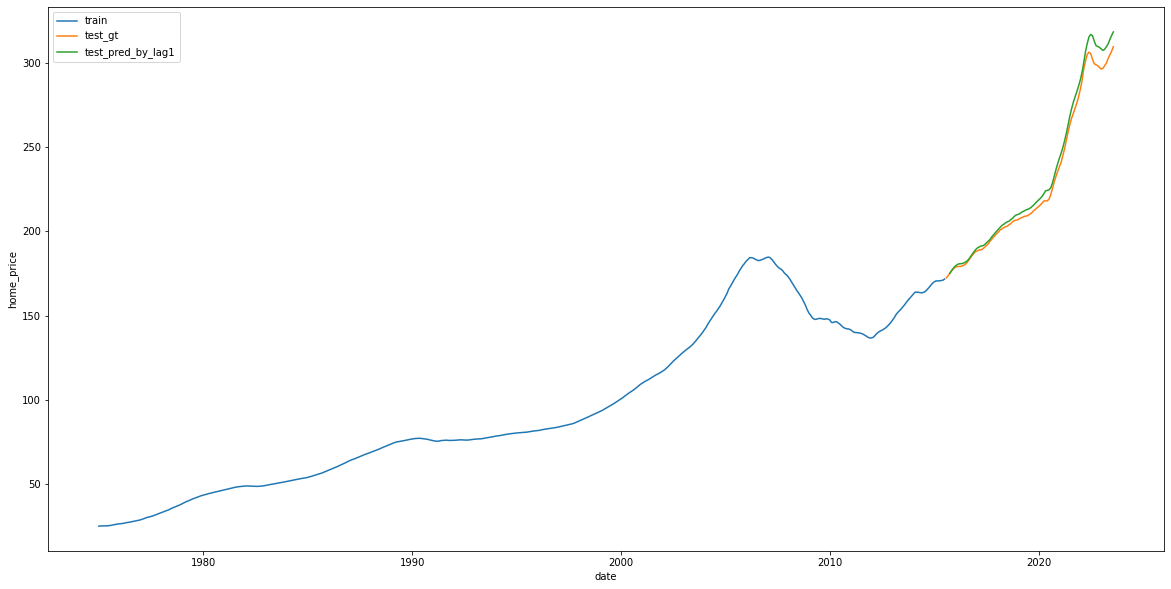

In [109]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='home_price', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='home_price', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='home_price_pred', data=y_price_pred.to_frame(name="home_price_pred"), label='test_pred_by_lag1', ax=ax)
plt.show()

## Simple AR Model

In [116]:
res_lag1 = model_lag1.get_prediction(df_test).summary_frame(alpha=0.05)
res_lag4 = model_lag4.get_prediction(df_test).summary_frame(alpha=0.05)

res_lag1.set_index(df_test.index, inplace=True)
res_lag4.set_index(df_test.index, inplace=True)

In [99]:
pred_by_lag4 = model_lag4.predict(df_test)
pred_by_lag1 = model_lag1.predict(df_test)
df_test['pred_by_lag4'] = pred_by_lag4
df_test['pred_by_lag1'] = pred_by_lag1

<ipython-input-99-4c07651c5ef5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_by_lag4'] = pred_by_lag4
<ipython-input-99-4c07651c5ef5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_by_lag1'] = pred_by_lag1


In [112]:
y_pred = model_lag1.predict(X_test)

In [113]:
rmse = lambda gt, pred: np.sqrt(mean_squared_error(gt, pred))

print("RMSE by AR(1) model: ", rmse(y_gt, y_pred))
print("MPAE by AR(1) model: ", mean_absolute_percentage_error(y_gt, y_pred))

RMSE by AR(1) model:  0.0027254077462649643
MPAE by AR(1) model:  21747619390.564243


In [114]:
start_price = df_test["home_price"].iloc[1]
y_price_gt = df_test.loc[X_test.index, "home_price"]
y_price_pred = np.exp(y_pred.cumsum() + np.log(start_price))
print("Price RMSE by AR(1) model: ", rmse(y_price_gt, y_price_pred))
print("Price MPAE by AR(1) model: ", mean_absolute_percentage_error(y_price_gt, y_price_pred))

Price RMSE by AR(1) model:  2.061164279858424
Price MPAE by AR(1) model:  0.005752037228536697


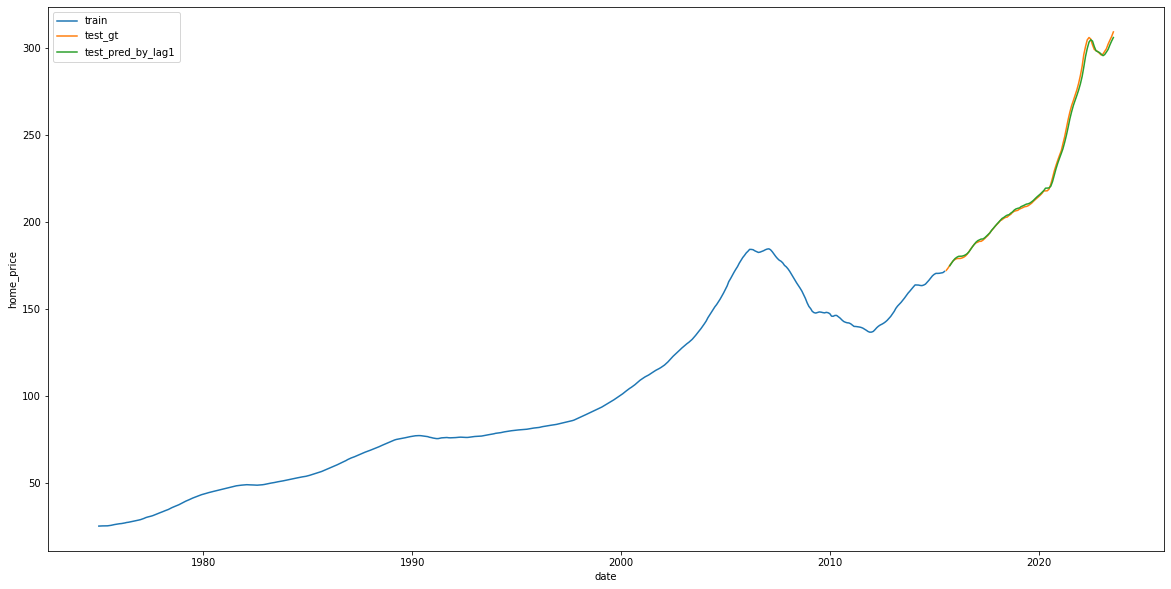

In [115]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='date', y='home_price', data=df_train, label='train', ax=ax)
sns.lineplot(x='date', y='home_price', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='date', y='home_price_pred', data=y_price_pred.to_frame(name="home_price_pred"), label='test_pred_by_lag1', ax=ax)
plt.show()

In [97]:
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# rmse = lambda gt, pred: np.sqrt(mean_squared_error(gt, pred))

# print("RMSE by AR(4) model: ", rmse(df_test['log_price_diff'], pred_by_lag4))
# print("MPAE by AR(4) model: ", mean_absolute_percentage_error(df_test['log_price_diff'], pred_by_lag4))

# print("RMSE by AR(1) model: ", rmse(df_test['log_price_diff'], pred_by_lag1))
# print("MPAE by AR(1) model: ", mean_absolute_percentage_error(df_test['log_price_diff'], pred_by_lag1))

RMSE by AR(4) model:  0.002618323813761834
MPAE by AR(4) model:  38831165666.05379
RMSE by AR(1) model:  0.002703025619008332
MPAE by AR(1) model:  20484865510.63242


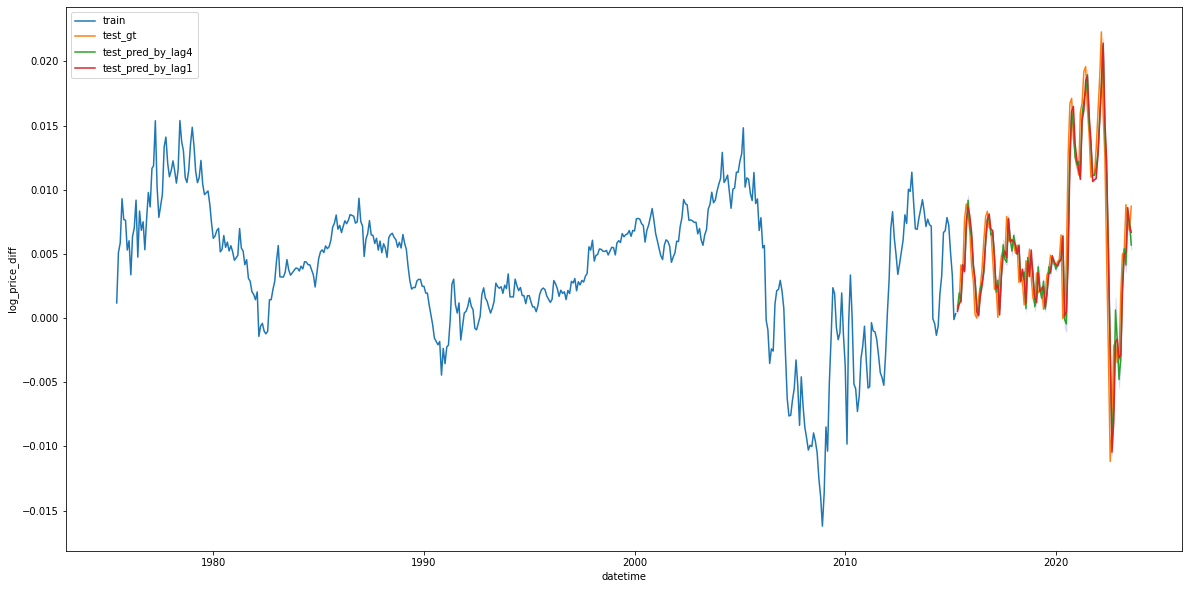

In [117]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='datetime', y='log_price_diff', data=df_train, label='train', ax=ax)
sns.lineplot(x='datetime', y='log_price_diff', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='datetime', y="pred_by_lag4", data=df_test, label='test_pred_by_lag4', ax=ax)
sns.lineplot(x='datetime', y="pred_by_lag1", data=df_test, label='test_pred_by_lag1', ax=ax)
ax.fill_between(df_test.index, res_lag4['mean_ci_lower'], res_lag4['mean_ci_upper'], color='b', alpha=0.1)
plt.show()

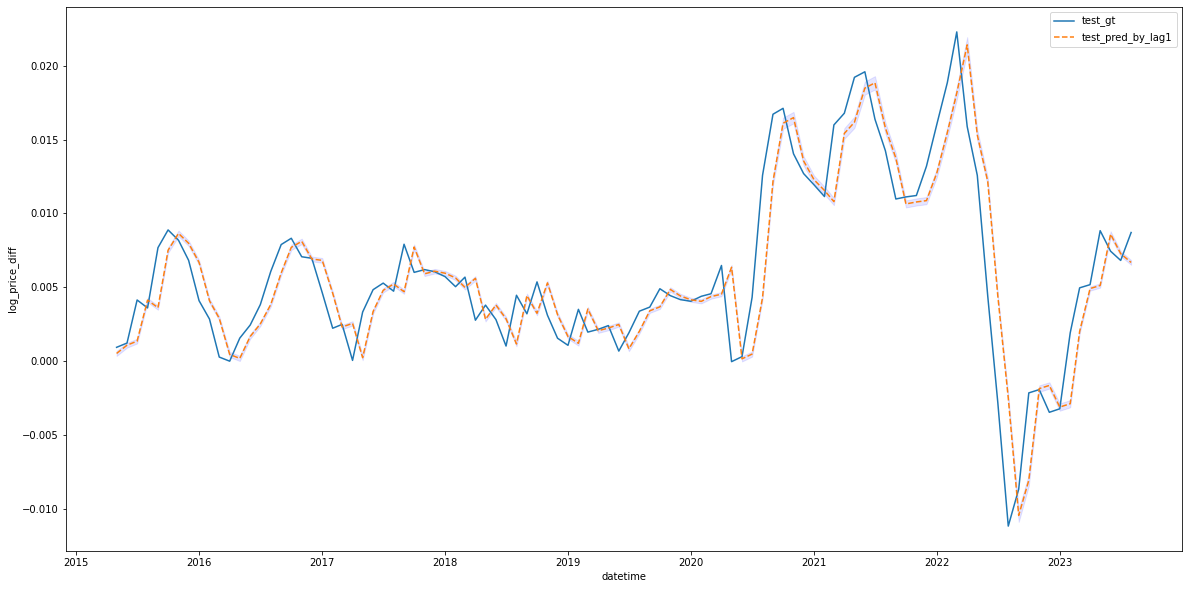

In [121]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='datetime', y='log_price_diff', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='datetime', y="pred_by_lag1", data=df_test, label='test_pred_by_lag1', linestyle='--', ax=ax)
ax.fill_between(df_test.index, res_lag1['mean_ci_lower'], res_lag1['mean_ci_upper'], color='b', alpha=0.1)
plt.show()

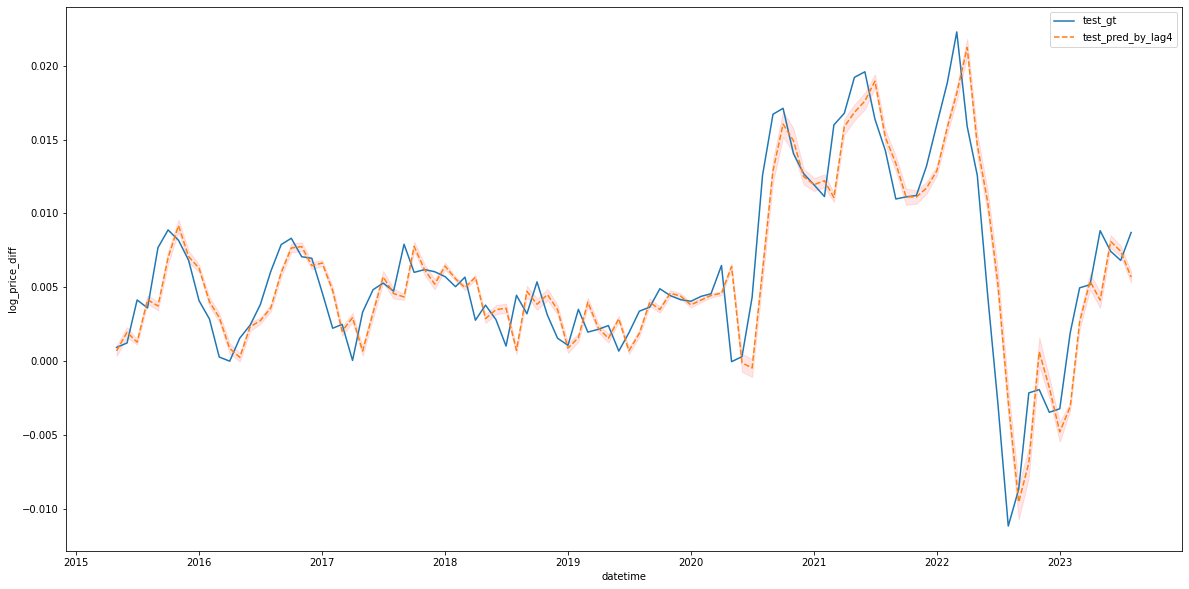

In [122]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='datetime', y='log_price_diff', data=df_test, label='test_gt', ax=ax )
sns.lineplot(x='datetime', y="pred_by_lag4", data=df_test, label='test_pred_by_lag4', linestyle='--', ax=ax)
ax.fill_between(df_test.index, res_lag4['mean_ci_lower'], res_lag4['mean_ci_upper'], color='r', alpha=0.1)
plt.show()